## Reading in files

Preprocessing data from csv

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read UK_df.csv as pandas dataframe
original_UK_dialogue = pd.read_csv('UK_df.csv')
original_UK_politeness = pd.read_csv('UK_direct_df.csv')
original_UK_narrator = pd.read_csv('UK_narrator_df.csv')
original_US_dialogue = pd.read_csv('US_df.csv')
original_US_politeness = pd.read_csv('US_direct_df.csv')
original_US_narrator = pd.read_csv('US_narrator_df.csv')
dataframes = [original_UK_dialogue, original_UK_politeness, original_UK_narrator, original_US_dialogue, original_US_politeness, original_US_narrator]

## Define universally relevant functions

For computing probs of model

In [ ]:
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt
def softmax(x):
    # Subtract the max value from x for numerical stability
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)
def construct_U_inf(narrator,z_score_type,plot_title,states):
    U_inf = dict()
    for utterence in narrator['intensifier'].unique():
        data = narrator[narrator['intensifier'] == utterence][z_score_type]
        kde = gaussian_kde(data) # kde is used so there is no zero
        densities_at_new_point = kde(states)  # This is the density at the new point
        # below is same as marginalizing so adds up to 1
        # plot kde as graph
        
        plt.plot(states, densities_at_new_point, label=utterence)
        plt.legend()
        plt.title(plot_title)

        # plot barplot of data
        U_inf[utterence] = np.log(densities_at_new_point)-np.log(np.sum(densities_at_new_point))
    return U_inf
def gaussian(s):
    # return a gaussian with mean 0 std 1
    return (1/np.sqrt(2*np.pi))*np.exp(-((s-0)**2)/2)
def U_s1(w,s,S,phi,cost,U_inf,U_soc):
    # corresponds to U_s1(w) in the paper
    if w[0] == 'none':
        # cost should be positive and represents how much easier it is to not have intensifier
        return phi*U_soc[w] + (1-phi)*U_inf[w[0]][int((s-S)*20)]+cost
    return phi*U_soc[w] + (1-phi)*U_inf[w[0]][int((s-S)*20)]
def construct_P_l1(U_inf,U_soc,costs,possible_alpha,possible_phi,states,predicates,intensifiers):
    P_l1 = dict()
    S = np.min(states)
    for cost in costs:
        P_s1 = dict()
        for alpha in possible_alpha:
            for phi in possible_phi:
                for s in states:
                    # marginalized over all utterences with same predicate ('none','slightly' 'kind of' 'quite' 'very' 'extremely')
                    for pred in predicates:
                        P_s1[(alpha,phi,s,pred)] = softmax([ alpha*U_s1((w,pred),s,S,phi,cost,U_inf,U_soc) for w in intensifiers])
        for alpha in possible_alpha:
            for phi in possible_phi:
                for i in range(len(intensifiers)):
                    for pred in predicates:
                        w = intensifiers[i]
                        P_l1[(alpha,phi,(w,pred),cost)] = [P_s1[(alpha,phi,s,pred)][i]*gaussian(s) for s in states]
                        # normalize so adds up to 1
                        P_l1[(alpha,phi,(w,pred),cost)] = P_l1[(alpha,phi,(w,pred),cost)]/np.sum(P_l1[(alpha,phi,(w,pred),cost)])
    return P_l1

Function for testing fit to data based on logloss

In [ ]:
def test_fit(dialogue,P_l1,z_score_type,possible_alpha,possible_phi,utterences,S):
    # test fit of model, by returning log loss for each utterence
    log_loss=dict()    
    for w in utterences:
        log_loss[w] = np.zeros((len(possible_phi),len(possible_alpha)))
        measured_values = dialogue[((dialogue['intensifier'] == w[0]) & (dialogue['predicate'] == w[1]))][z_score_type].values
        for i in range(len(possible_phi)):
            for j in range(len(possible_alpha)):
                log_loss[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w)][int((s-S)*20)]) for s in measured_values)
    return log_loss

# Version with cost

# Version without cost (taking difs)

In [ ]:
def clean_data(df):
    # dropped Unnamed: 0 column
    df.drop(columns=['Unnamed: 0'], inplace=True)
    filtered_df = df.loc[(df['response'] > 95) | (df['response'] < 5)]
    for id in df['person_id'].unique():
        if len(filtered_df[filtered_df['person_id'] == id])/len(df[df['person_id'] == id])>0.8:
            df.drop(df[df['person_id'] == id].index, inplace=True)
    # only keep columns with has_intensifier = yes
    return df[df['has intensifier?'] == 'yes']
for i in range(len(dataframes)):
    dataframes[i] = clean_data(dataframes[i])
politeness = pd.concat([dataframes[1], dataframes[4]])
narrator = pd.concat([dataframes[2], dataframes[5]])
dialogue = pd.concat([dataframes[0], dataframes[3]])
UK_dialogue = dataframes[0]
UK_politeness = dataframes[1]
UK_narrator = dataframes[2]
US_dialogue = dataframes[3]
US_politeness = dataframes[4]
US_narrator = dataframes[5]

Compute U_soc from politeness data

In [ ]:
# create key with intensifier and predicate as a tuple and value as Z-Score Difference
U_soc_dif = politeness.set_index(['intensifier', 'predicate'])['Z-Score Difference'].to_dict()

Visualize raw responses: ones where responses are always at endpoints are dropped.

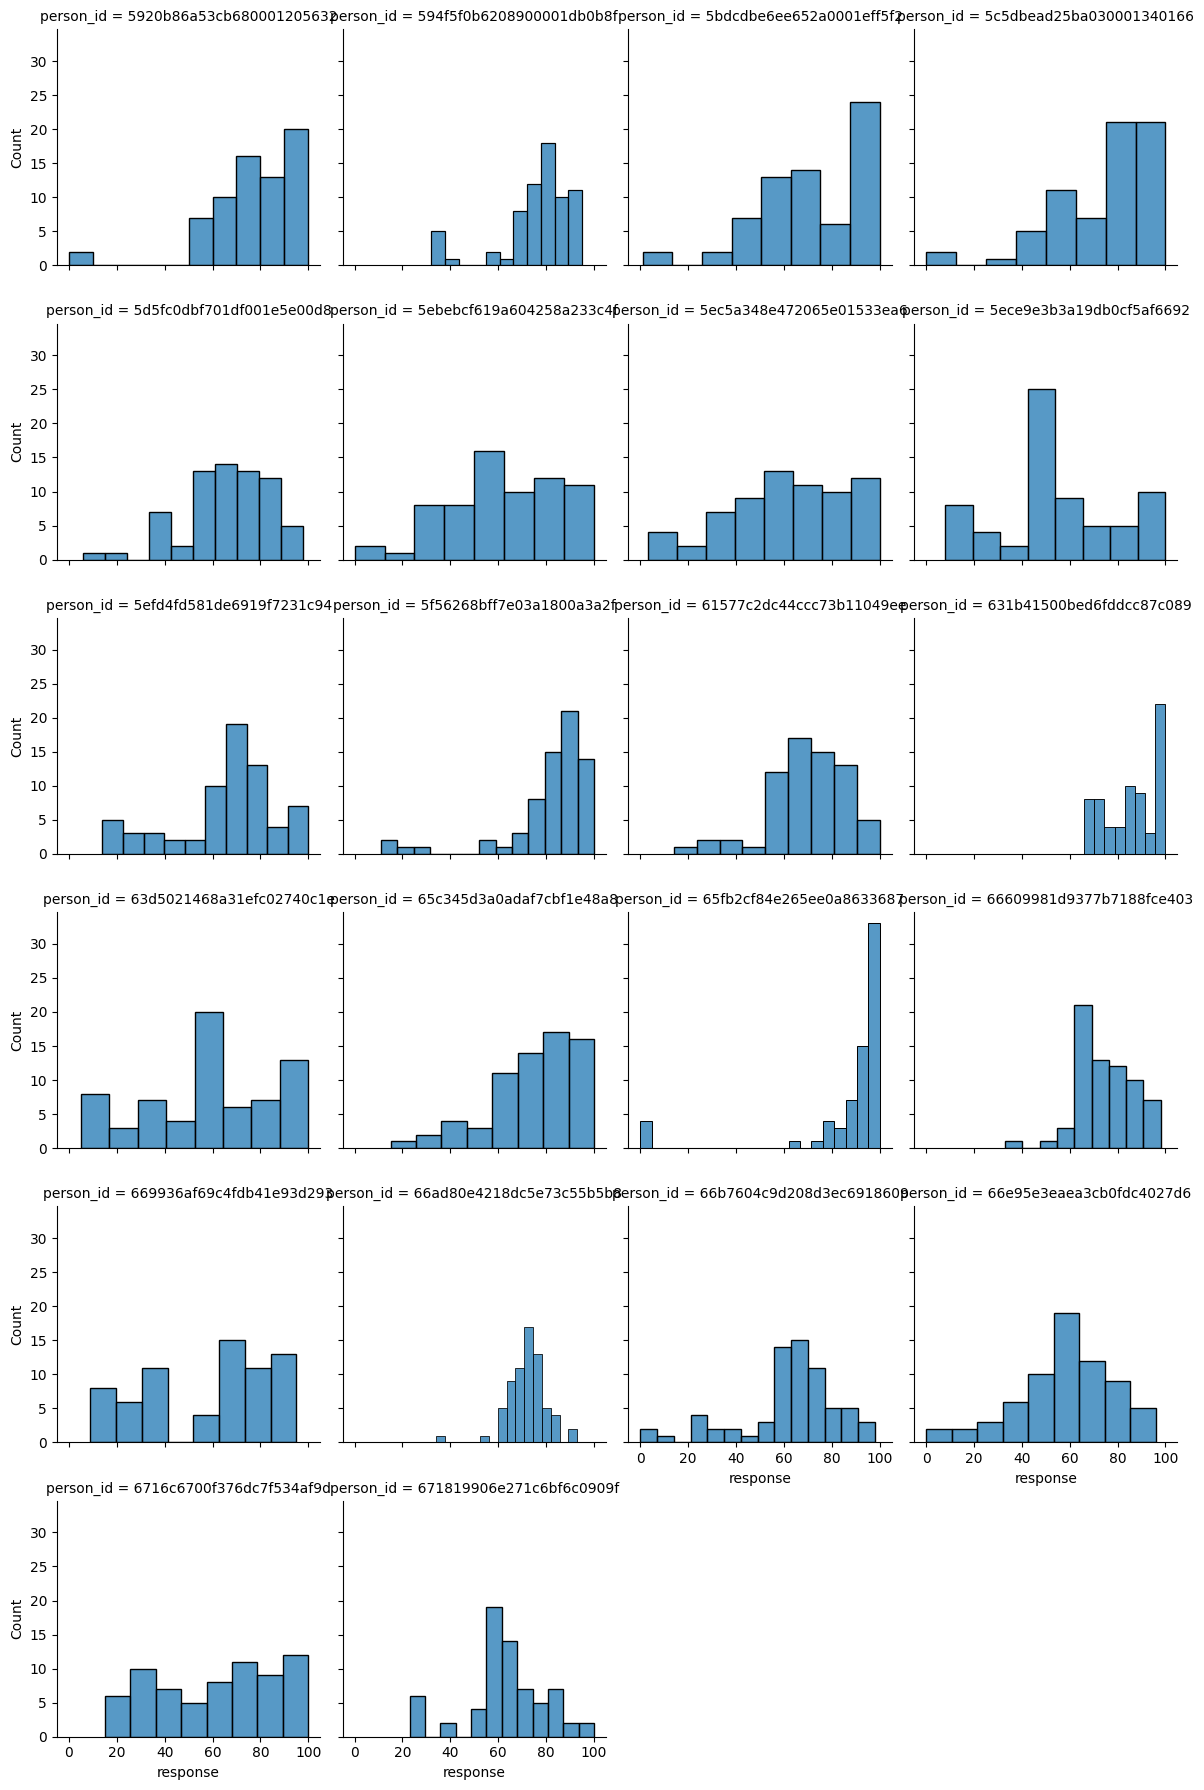

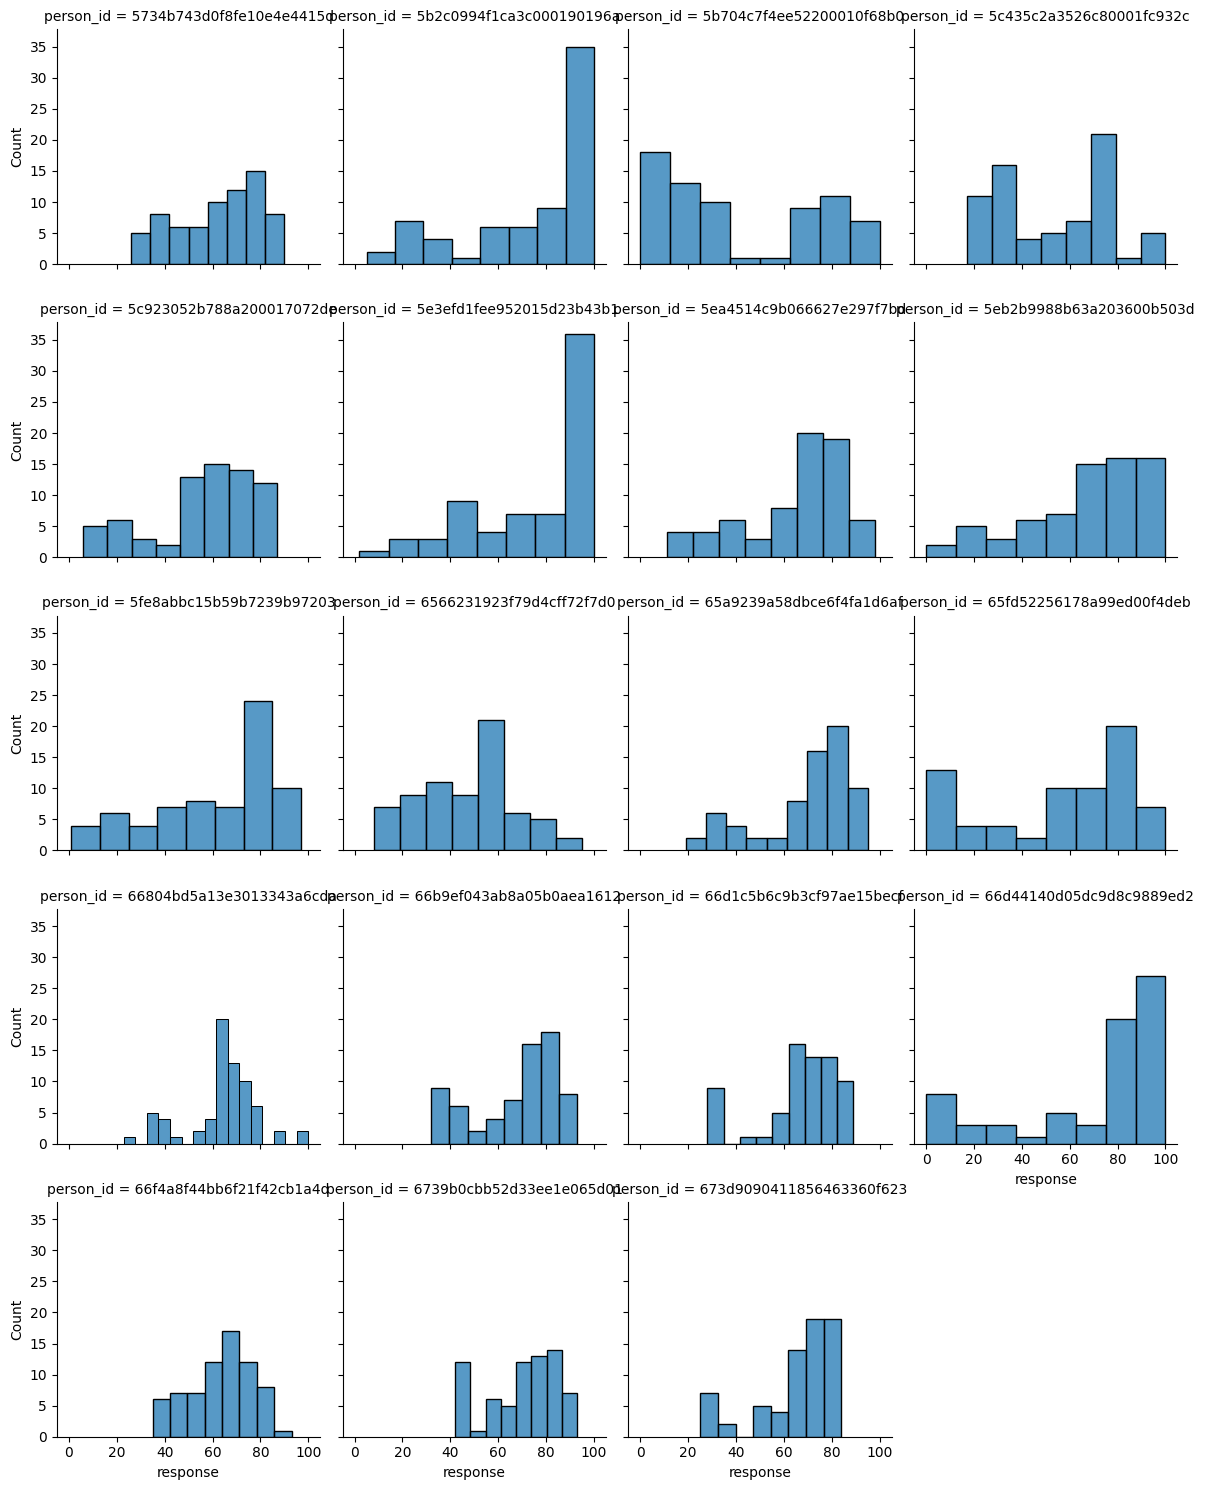

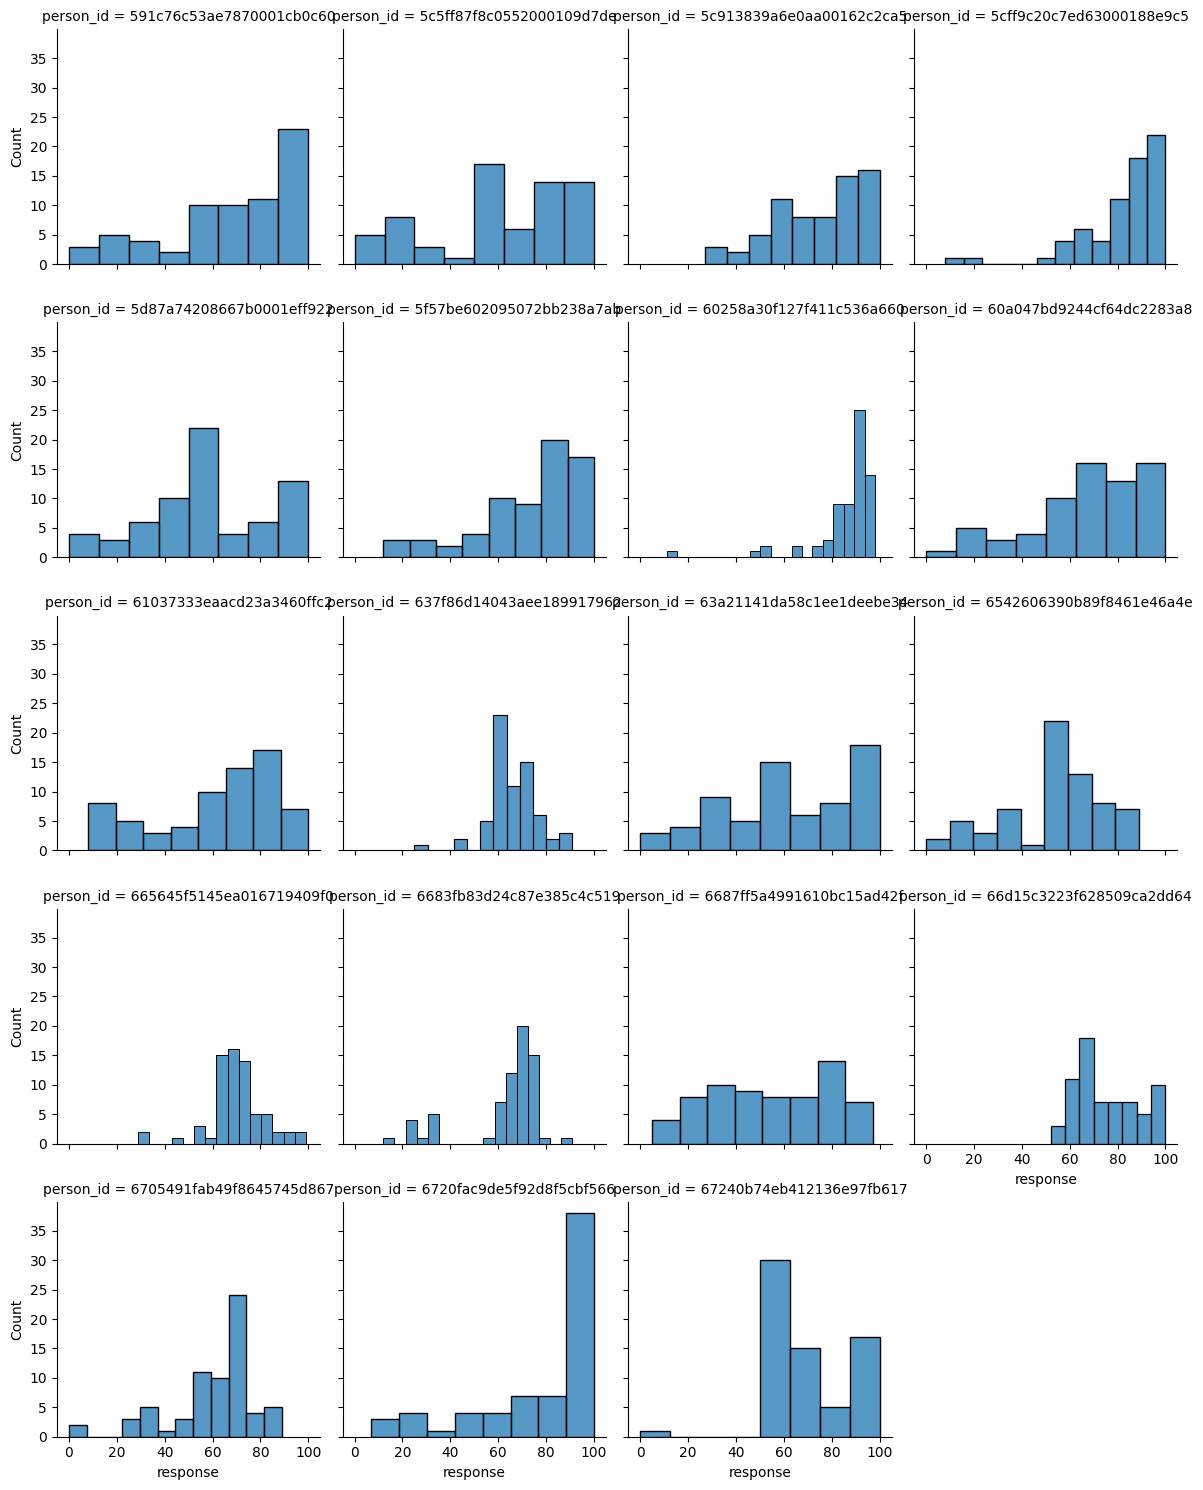

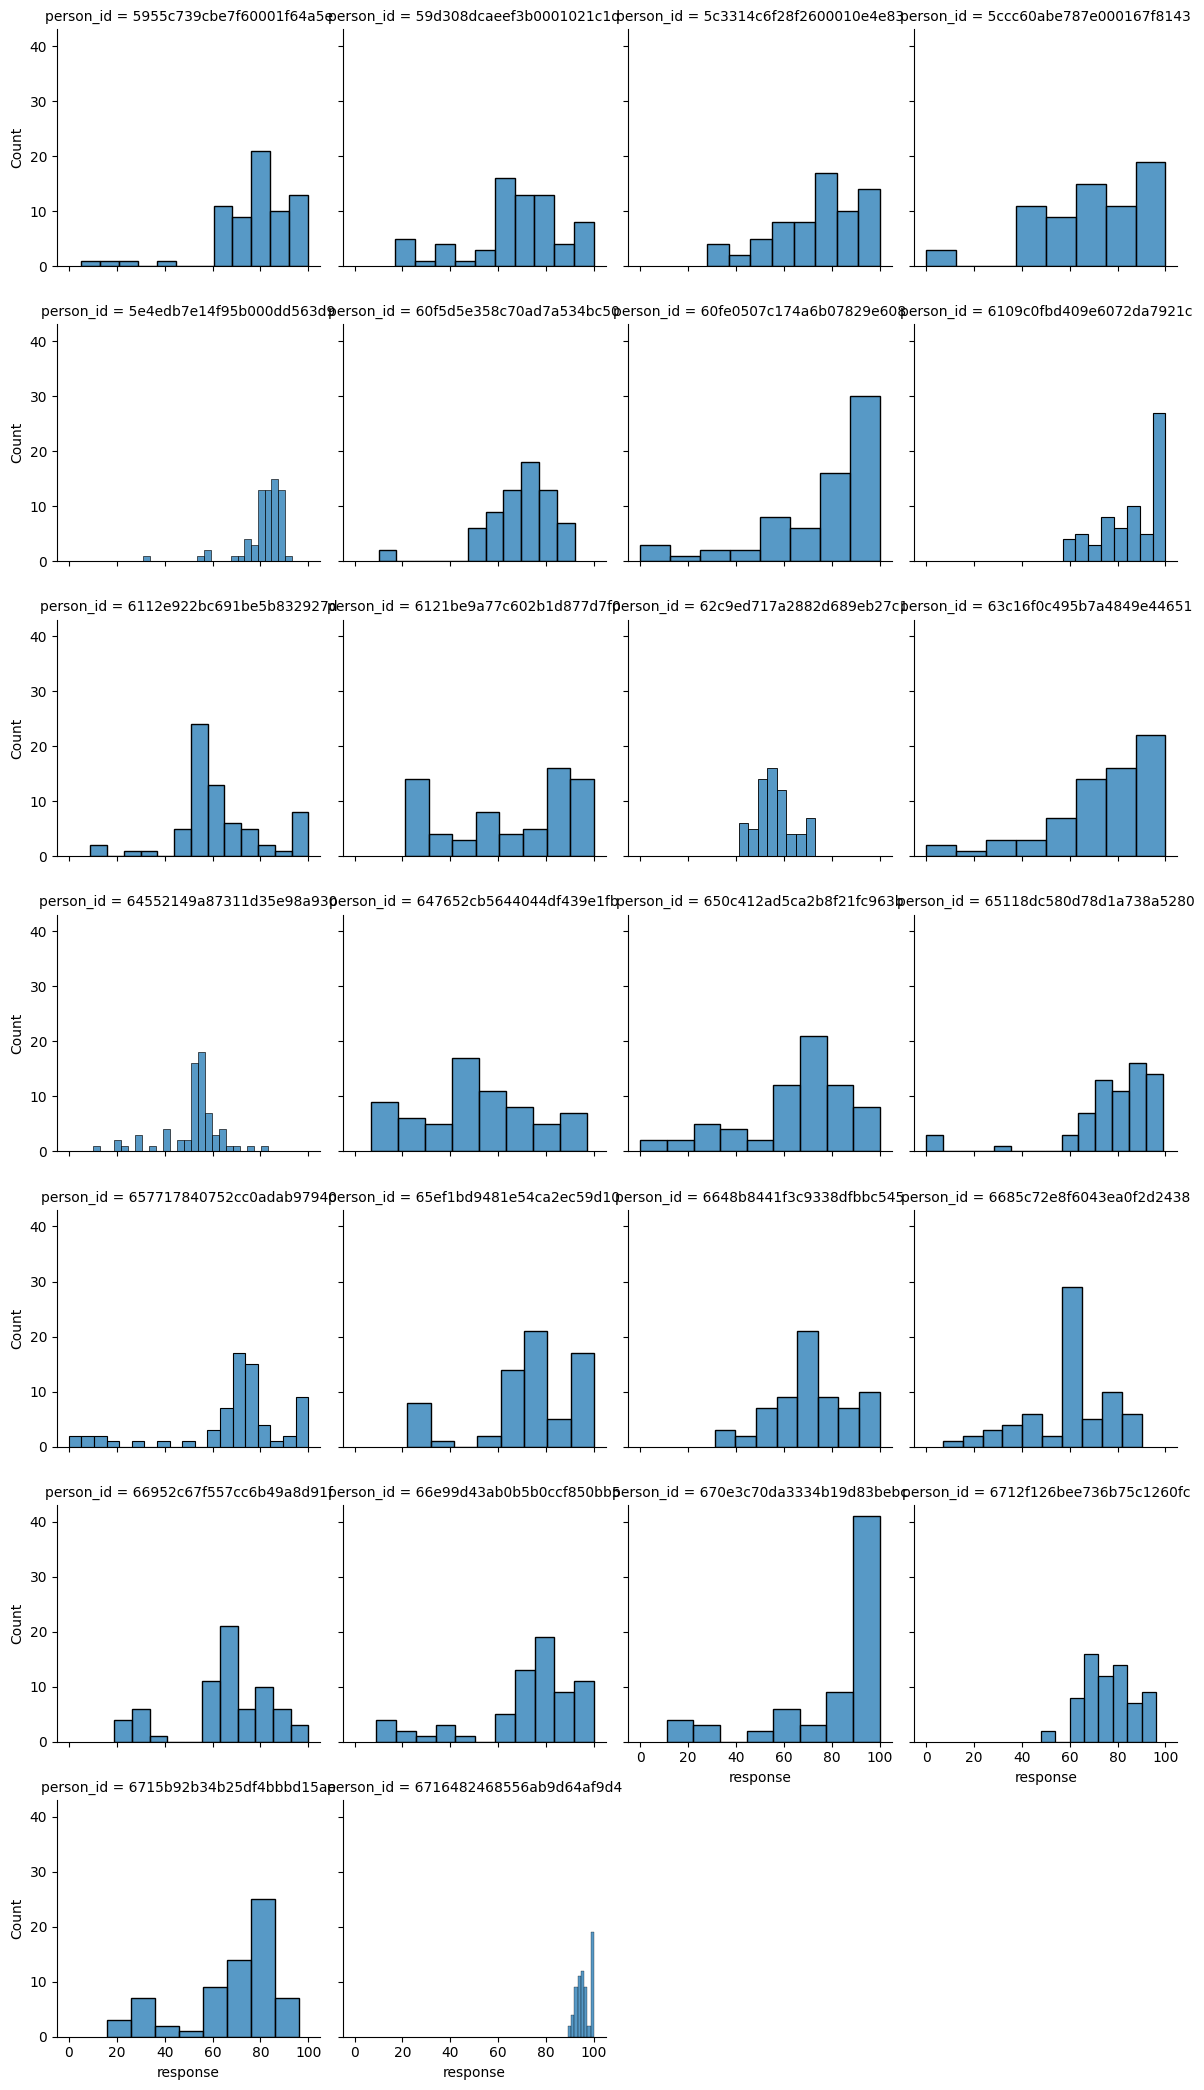

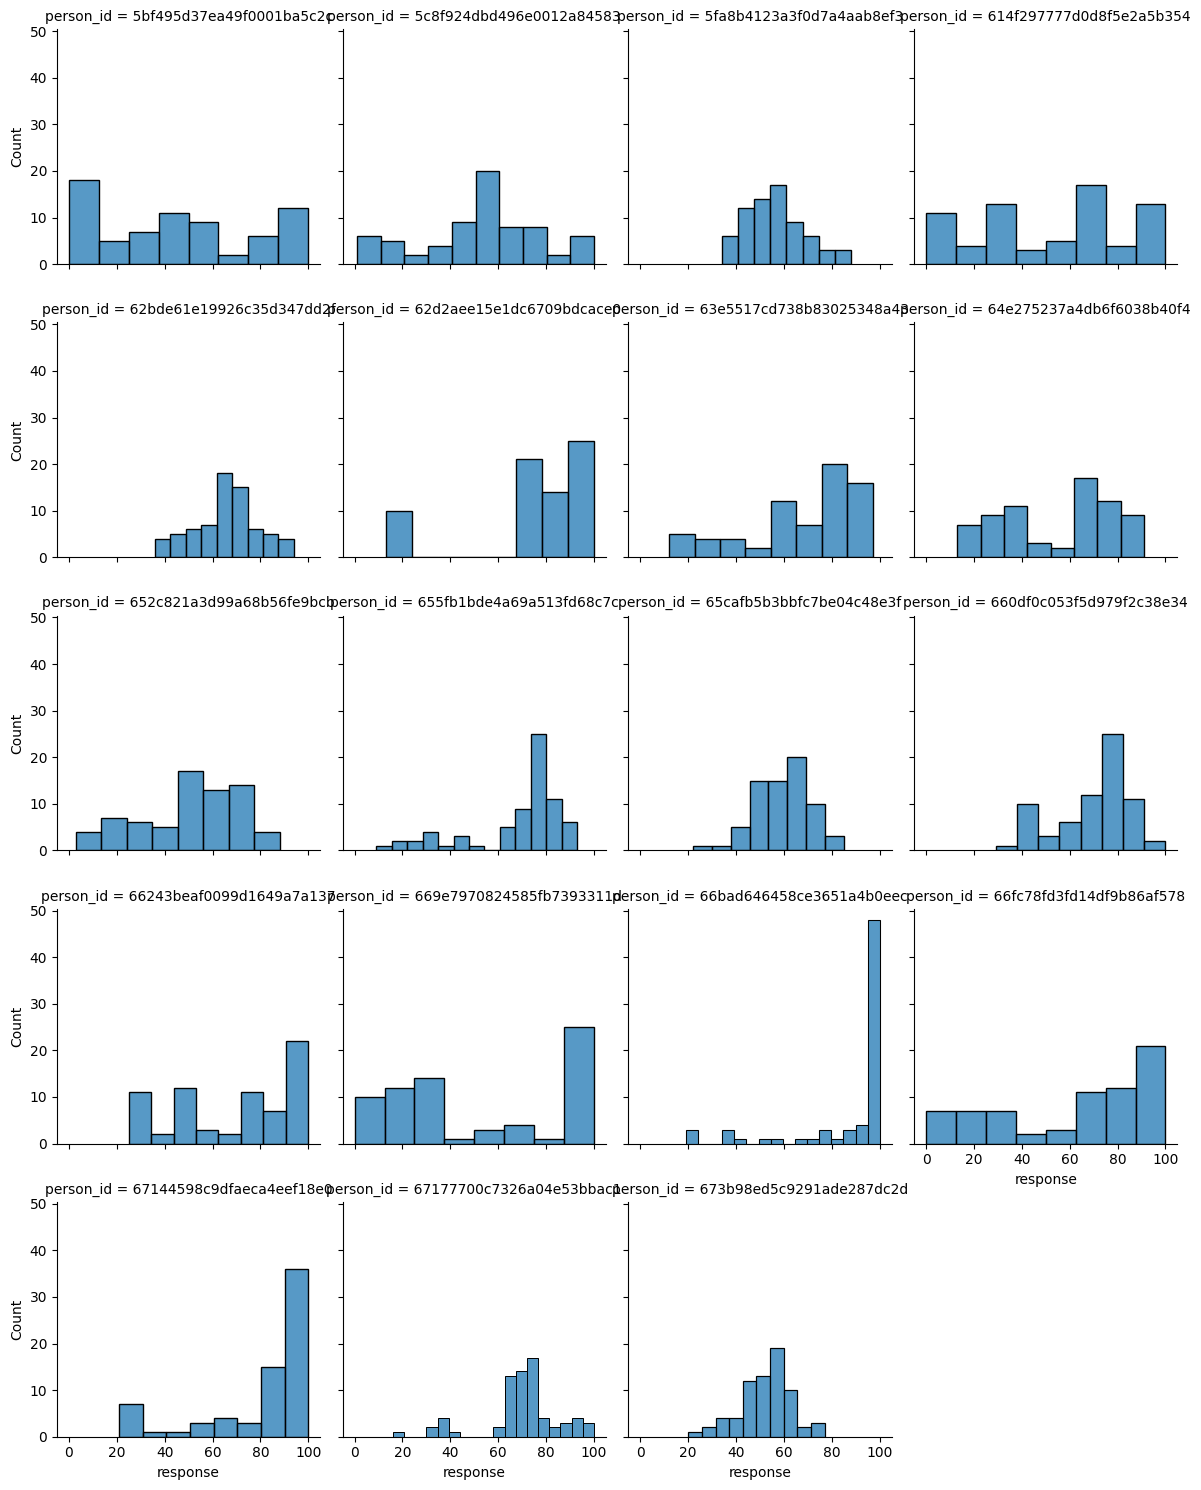

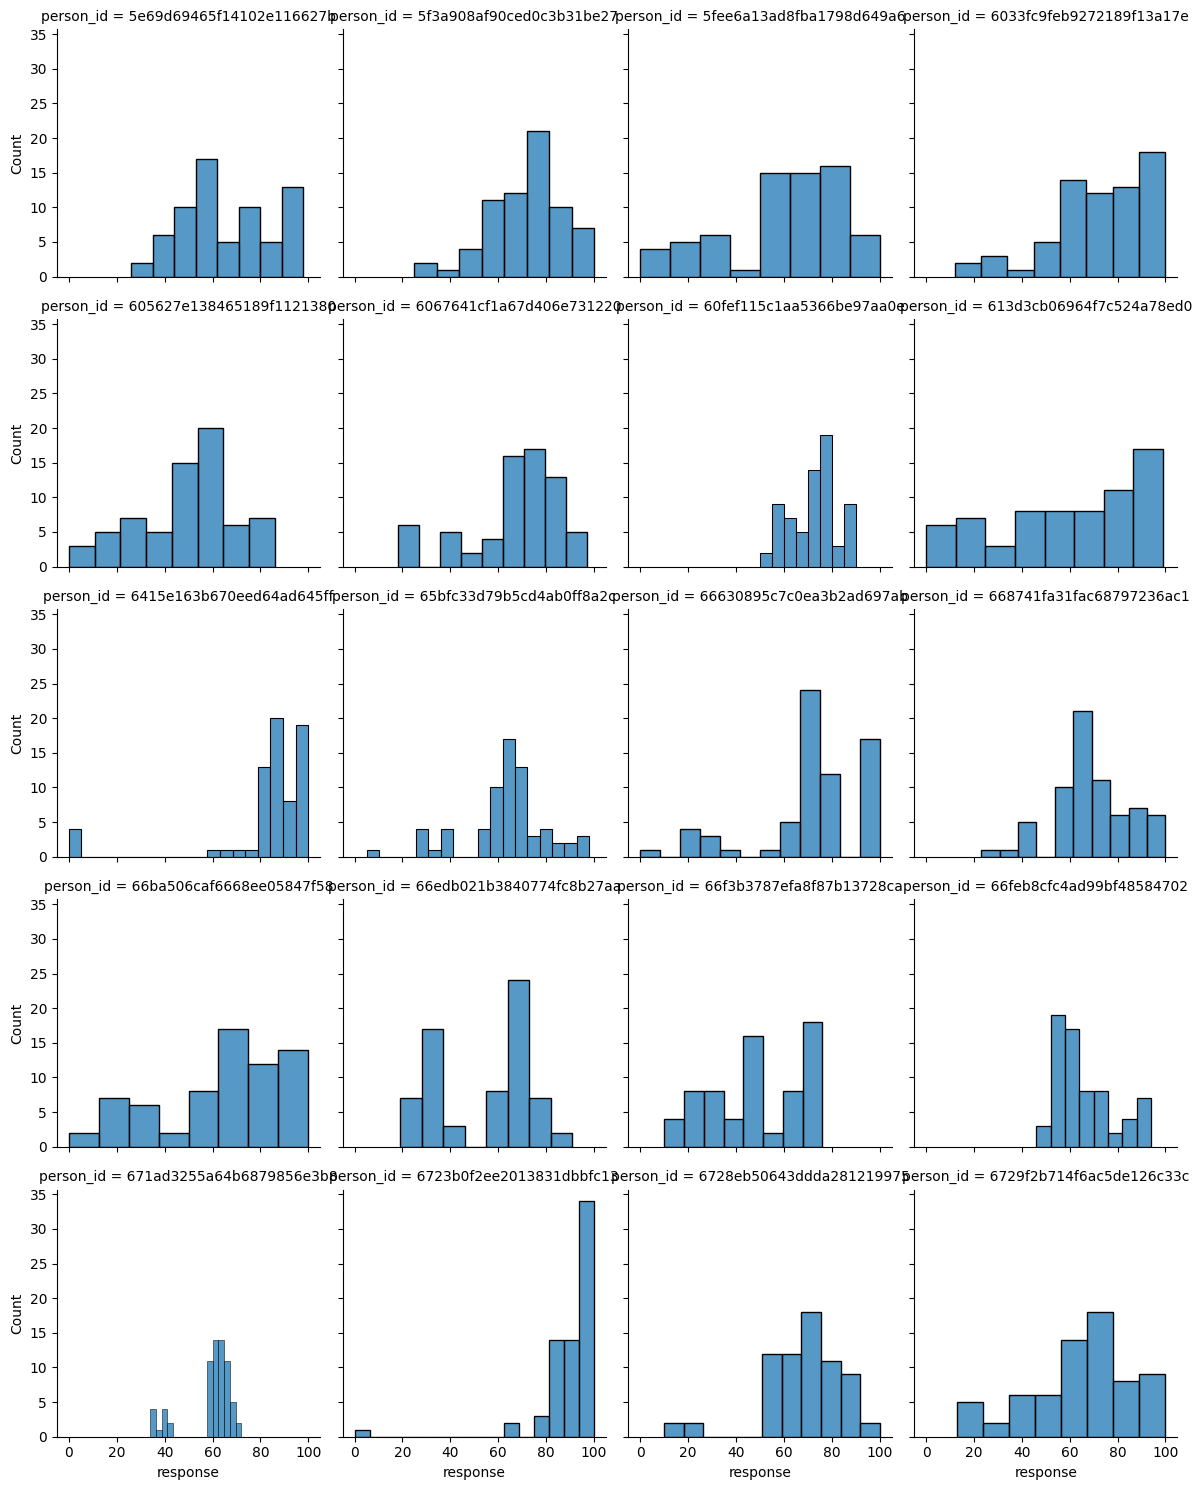

In [282]:
import seaborn as sns
for data in [UK_dialogue, UK_politeness, UK_narrator, US_dialogue, US_politeness, US_narrator]:
    sns.FacetGrid(data, col="person_id", col_wrap=4).map(sns.histplot, "response")

## Test fit with data

C:\Users\myuhk\AppData\Local\Temp\ipykernel_33316\1977602079.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w)][int(s)+100]) for s in measured_values)


Compute $P_{L_0}(state | utterance)$ (used kde to make plots smooth so no 0 probs)

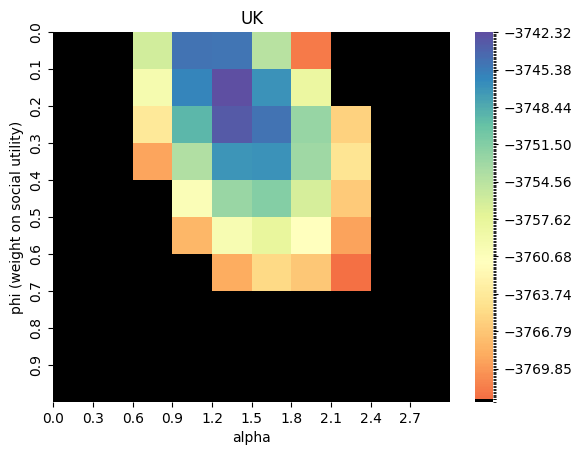

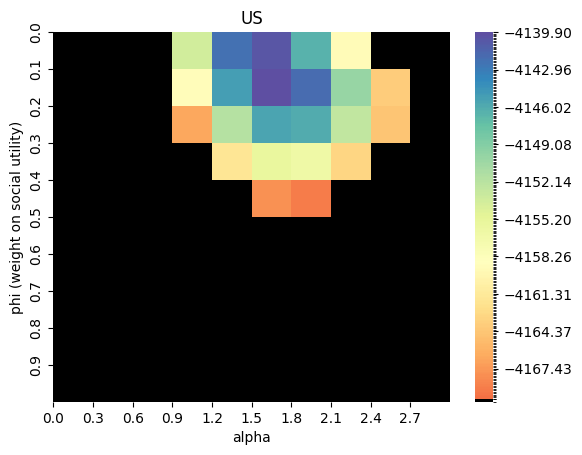

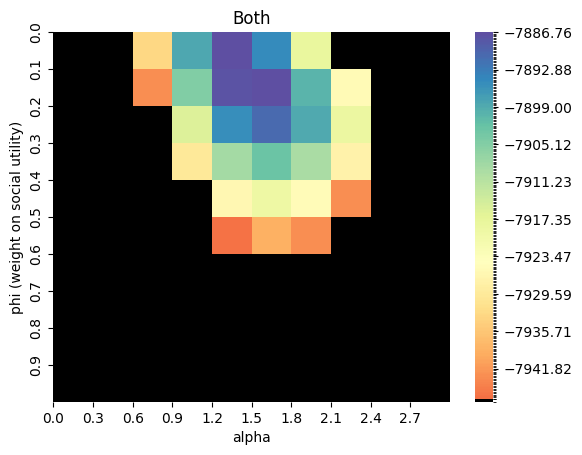

US best fit: (1, 5)
UK best fit: (1, 4)
best fit: (1, 5)


In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
# Define a custom colormap
base_cmap = sns.color_palette("Spectral", as_cmap=True)  # Base colormap
colors = ["black"] + list(base_cmap(np.linspace(0.2, 1, 256)))  # Add black for below threshold
custom_cmap = ListedColormap(colors)

def plot_overall_fit(fit_judgement, possible_alpha, possible_phi,title,minus_thresh):
    # Define a normalization function
    threshold = np.max(np.sum([fit_judgement[w] for w in utterences],axis=0))+minus_thresh
    bounds = [-20000, threshold] + list(np.linspace(threshold, np.max(np.sum([fit_judgement[w] for w in utterences],axis=0)), 256))
    norm = BoundaryNorm(bounds, len(bounds) - 1)
    sns.heatmap(np.sum([fit_judgement[w] for w in utterences],axis=0), cmap=custom_cmap, norm=norm, cbar=True)# label x and y by the possible values
    plt.xticks(range(len(possible_alpha)), [round(x, 2) for x in possible_alpha])
    plt.yticks(range(len(possible_phi)), [round(x, 2) for x in possible_phi])
    # label x and y axis
    plt.xlabel('alpha')
    plt.ylabel('phi (weight on social utility)')
    # label colors in heatmap
    plt.title(title)
    # plt.colorbar()
    plt.show()
plot_overall_fit(UK_fit_judgement,possible_alpha,possible_phi,'UK',-30)
plot_overall_fit(US_fit_judgement,possible_alpha,possible_phi,'US',-30)
# plot both
plot_overall_fit(fit_judgement,possible_alpha,possible_phi,'Both',-60)


## Visualizing results

In [ ]:
def best_coord_val(fit_judgement):
    best_coord = np.unravel_index(np.argmax(fit_judgement, axis=None))
    best_val = fit_judgement[best_coord]
    return best_coord, best_val
print(f"US best fit: {best_coord_val(np.sum([US_fit_judgement[w] for w in utterences],axis=0))}")

## Do the same thing but using Z-Score Difference as the state values

slightly -0.8476396444174623
kind of -0.34639293611900196
quite -0.1434112423146401
very 0.31508649534802086
extremely 0.423307572687601


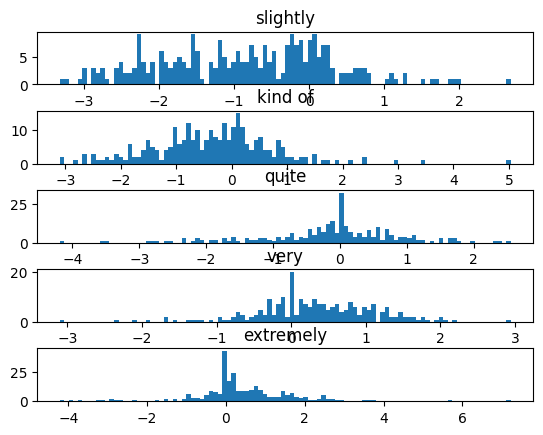

In [ ]:
# plot frequency of values in narrator[narrator['intensifier'] == 'very']['Z-Score Difference'].values
intensifiers = narrator['intensifier'].unique()
for i in range(len(intensifiers)):
    plt.subplot(5, 1, i+1)
    # give more space between subplots
    plt.subplots_adjust(hspace=0.5)
    plt.hist(narrator[narrator['intensifier'] == intensifiers[i]]['Z-Score Difference'].values, bins=100)
    plt.title(intensifiers[i])


implementing computational model

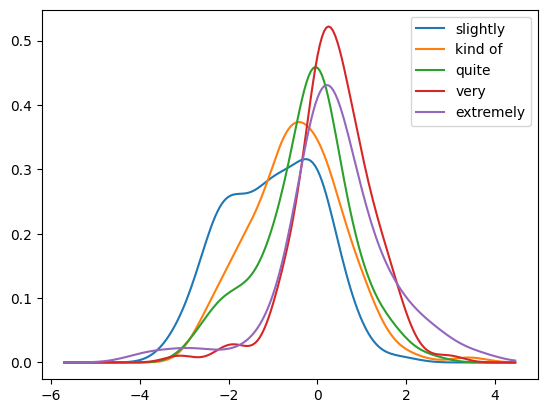

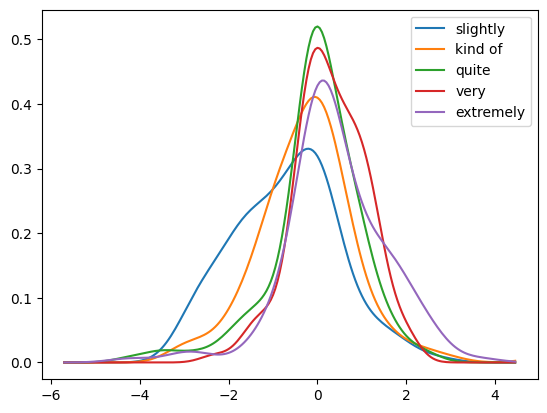

C:\Users\myuhk\AppData\Local\Temp\ipykernel_12972\1603338753.py:79: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w)][int((s-S)*20)]) for s in measured_values)


In [180]:
import numpy as np
utterences =list(U_soc.keys())
predicates = list(set(w[1] for w in utterences))
intensifiers = list(set(w[0] for w in utterences))
states = np.arange(-5.7, 4.5, 0.05)
S = np.min(states)
UK_U_inf = dict()
US_U_inf = dict()
possible_phi = np.arange(0,1,0.05)
possible_alpha = np.arange(0,3,0.15)
for utterence in UK_narrator['intensifier'].unique():
    data = UK_narrator[UK_narrator['intensifier'] == utterence]['Z-Score Difference']
    kde = gaussian_kde(data)
    densities_at_new_point = kde(states)  # This is the density at the new point
    # below is same as marginalizing so adds up to 1
    # plot kde as graph
    plt.plot(states, densities_at_new_point, label=utterence)
    UK_U_inf[utterence] = np.log(densities_at_new_point)-np.log(np.sum(densities_at_new_point))
plt.legend()
plt.show()
for utterence in US_narrator['intensifier'].unique():
    data = US_narrator[US_narrator['intensifier'] == utterence]['Z-Score Difference']
    kde = gaussian_kde(data)
    densities_at_new_point = kde(states)  # This is the density at the new point
    # below is same as marginalizing so adds up to 1
    # plot kde as graph
    plt.plot(states, densities_at_new_point, label=utterence)
    US_U_inf[utterence] = np.log(densities_at_new_point)-np.log(np.sum(densities_at_new_point))
plt.legend()
plt.show()
def P_state(s):
    # prior over states, but subject to change
    # return a gaussian with mean 0 std 1
    return (1/np.sqrt(2*np.pi))*np.exp(-((s-0)**2)/2)
def U_s1(w,s,phi,U_soc,U_inf):
    # corresponds to U_s1(w) in the paper
    return phi*U_soc[w] + (1-phi)*U_inf[w[0]][int((s-S)*20)]
# s spans from -100 to 100
UK_P_s1 = dict() # corresponds to P_S1(w|s,phi)
for alpha in possible_alpha:
    for phi in possible_phi:
        for s in states:
            # marginalized over all utterences with same predicate ('slightly' 'kind of' 'quite' 'very' 'extremely')
            for pred in predicates:
                UK_P_s1[(alpha,phi,s,pred)] = softmax([ alpha*U_s1((w,pred),s,phi,U_soc,UK_U_inf) for w in intensifiers])
US_P_s1 = dict() # corresponds to P_S1(w|s,phi)
for alpha in possible_alpha:
    for phi in possible_phi:
        for s in states:
            # marginalized over all utterences with same predicate ('slightly' 'kind of' 'quite' 'very' 'extremely')
            for pred in predicates:
                US_P_s1[(alpha,phi,s,pred)] = softmax([ alpha*U_s1((w,pred),s,phi,U_soc,US_U_inf) for w in intensifiers])
UK_P_l1 = dict()# corresponds to P_L1(s|w,phi)
for alpha in possible_alpha:
    for phi in possible_phi:
        for i in range(len(intensifiers)):
            for pred in predicates:
                w = intensifiers[i]
                UK_P_l1[(alpha,phi,(w,pred))] = [UK_P_s1[(alpha,phi,s,pred)][i]*P_state(s) for s in states]
                # normalize so adds up to 1
                UK_P_l1[(alpha,phi,(w,pred))] = UK_P_l1[(alpha,phi,(w,pred))]/np.sum(UK_P_l1[(alpha,phi,(w,pred))])
US_P_l1 = dict()# corresponds to P_L1(s|w,phi)
for alpha in possible_alpha:
    for phi in possible_phi:
        for i in range(len(intensifiers)):
            for pred in predicates:
                w = intensifiers[i]
                US_P_l1[(alpha,phi,(w,pred))] = [US_P_s1[(alpha,phi,s,pred)][i]*P_state(s) for s in states]
                # normalize so adds up to 1
                US_P_l1[(alpha,phi,(w,pred))] = US_P_l1[(alpha,phi,(w,pred))]/np.sum(US_P_l1[(alpha,phi,(w,pred))])
def test_fit(data,P_l1):
    # test fit of model, P_l1 with data
    fit_judgement=dict()    
    for w in utterences:
        fit_judgement[w] = np.zeros((len(possible_phi),len(possible_alpha)))
        measured_values = data[((data['intensifier'] == w[0]) & (data['predicate'] == w[1]))]['Z-Score Difference'].values
        for i in range(len(possible_phi)):
            for j in range(len(possible_alpha)):
                fit_judgement[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w)][int((s-S)*20)]) for s in measured_values)
    return fit_judgement
UK_specific_fit = test_fit(UK_dialogue,UK_P_l1)
US_specific_fit = test_fit(US_dialogue,US_P_l1)

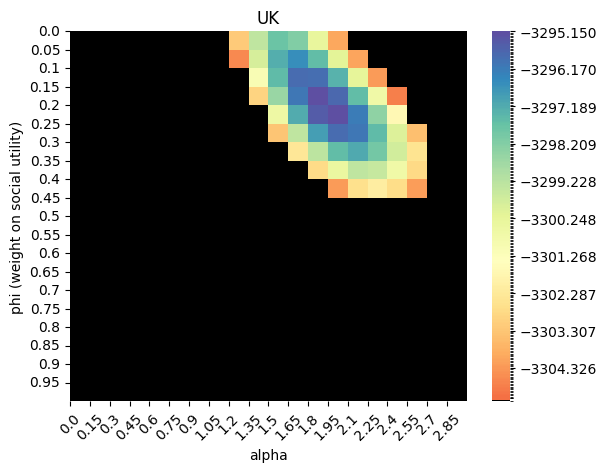

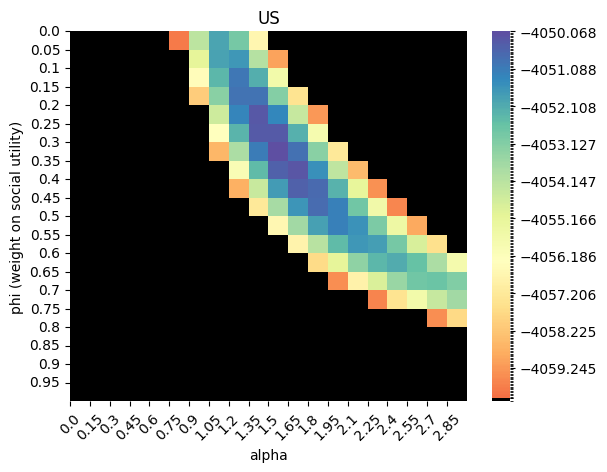

UK best fit: (3, 12)
US best fit: (6, 10)


In [184]:
def plot_fits(fit_judgement, possible_alpha, possible_phi,title,minus_thresh):
    # Define a normalization function
    threshold = np.max(np.sum([fit_judgement[w] for w in utterences],axis=0))+minus_thresh
    bounds = [-10000, threshold] + list(np.linspace(threshold, np.max(np.sum([fit_judgement[w] for w in utterences],axis=0)), 256))
    norm = BoundaryNorm(bounds, len(bounds) - 1)
    sns.heatmap(np.sum([fit_judgement[w] for w in utterences],axis=0), cmap=custom_cmap, norm=norm, cbar=True)# label x and y by the possible values
    plt.xticks(range(len(possible_alpha)), [round(x, 2) for x in possible_alpha])
    plt.yticks(range(len(possible_phi)), [round(x, 2) for x in possible_phi])
    # label x and y axis
    plt.xlabel('alpha')
    plt.ylabel('phi (weight on social utility)')
    # rotate y ticks by 90
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    # label colors in heatmap
    plt.title(title)
    # plt.colorbar()
    plt.show()
plot_fits(UK_specific_fit,possible_alpha,possible_phi,'UK',-10)
plot_fits(US_specific_fit,possible_alpha,possible_phi,'US',-10)
# print best fit for US and UK
print(f"UK best fit: {np.unravel_index(np.argmax(np.sum([UK_specific_fit[w] for w in utterences],axis=0), axis=None), np.sum([UK_specific_fit[w] for w in utterences],axis=0).shape)}")
print(f"US best fit: {np.unravel_index(np.argmax(np.sum([US_specific_fit[w] for w in utterences],axis=0), axis=None), np.sum([US_specific_fit[w] for w in utterences],axis=0).shape)}")

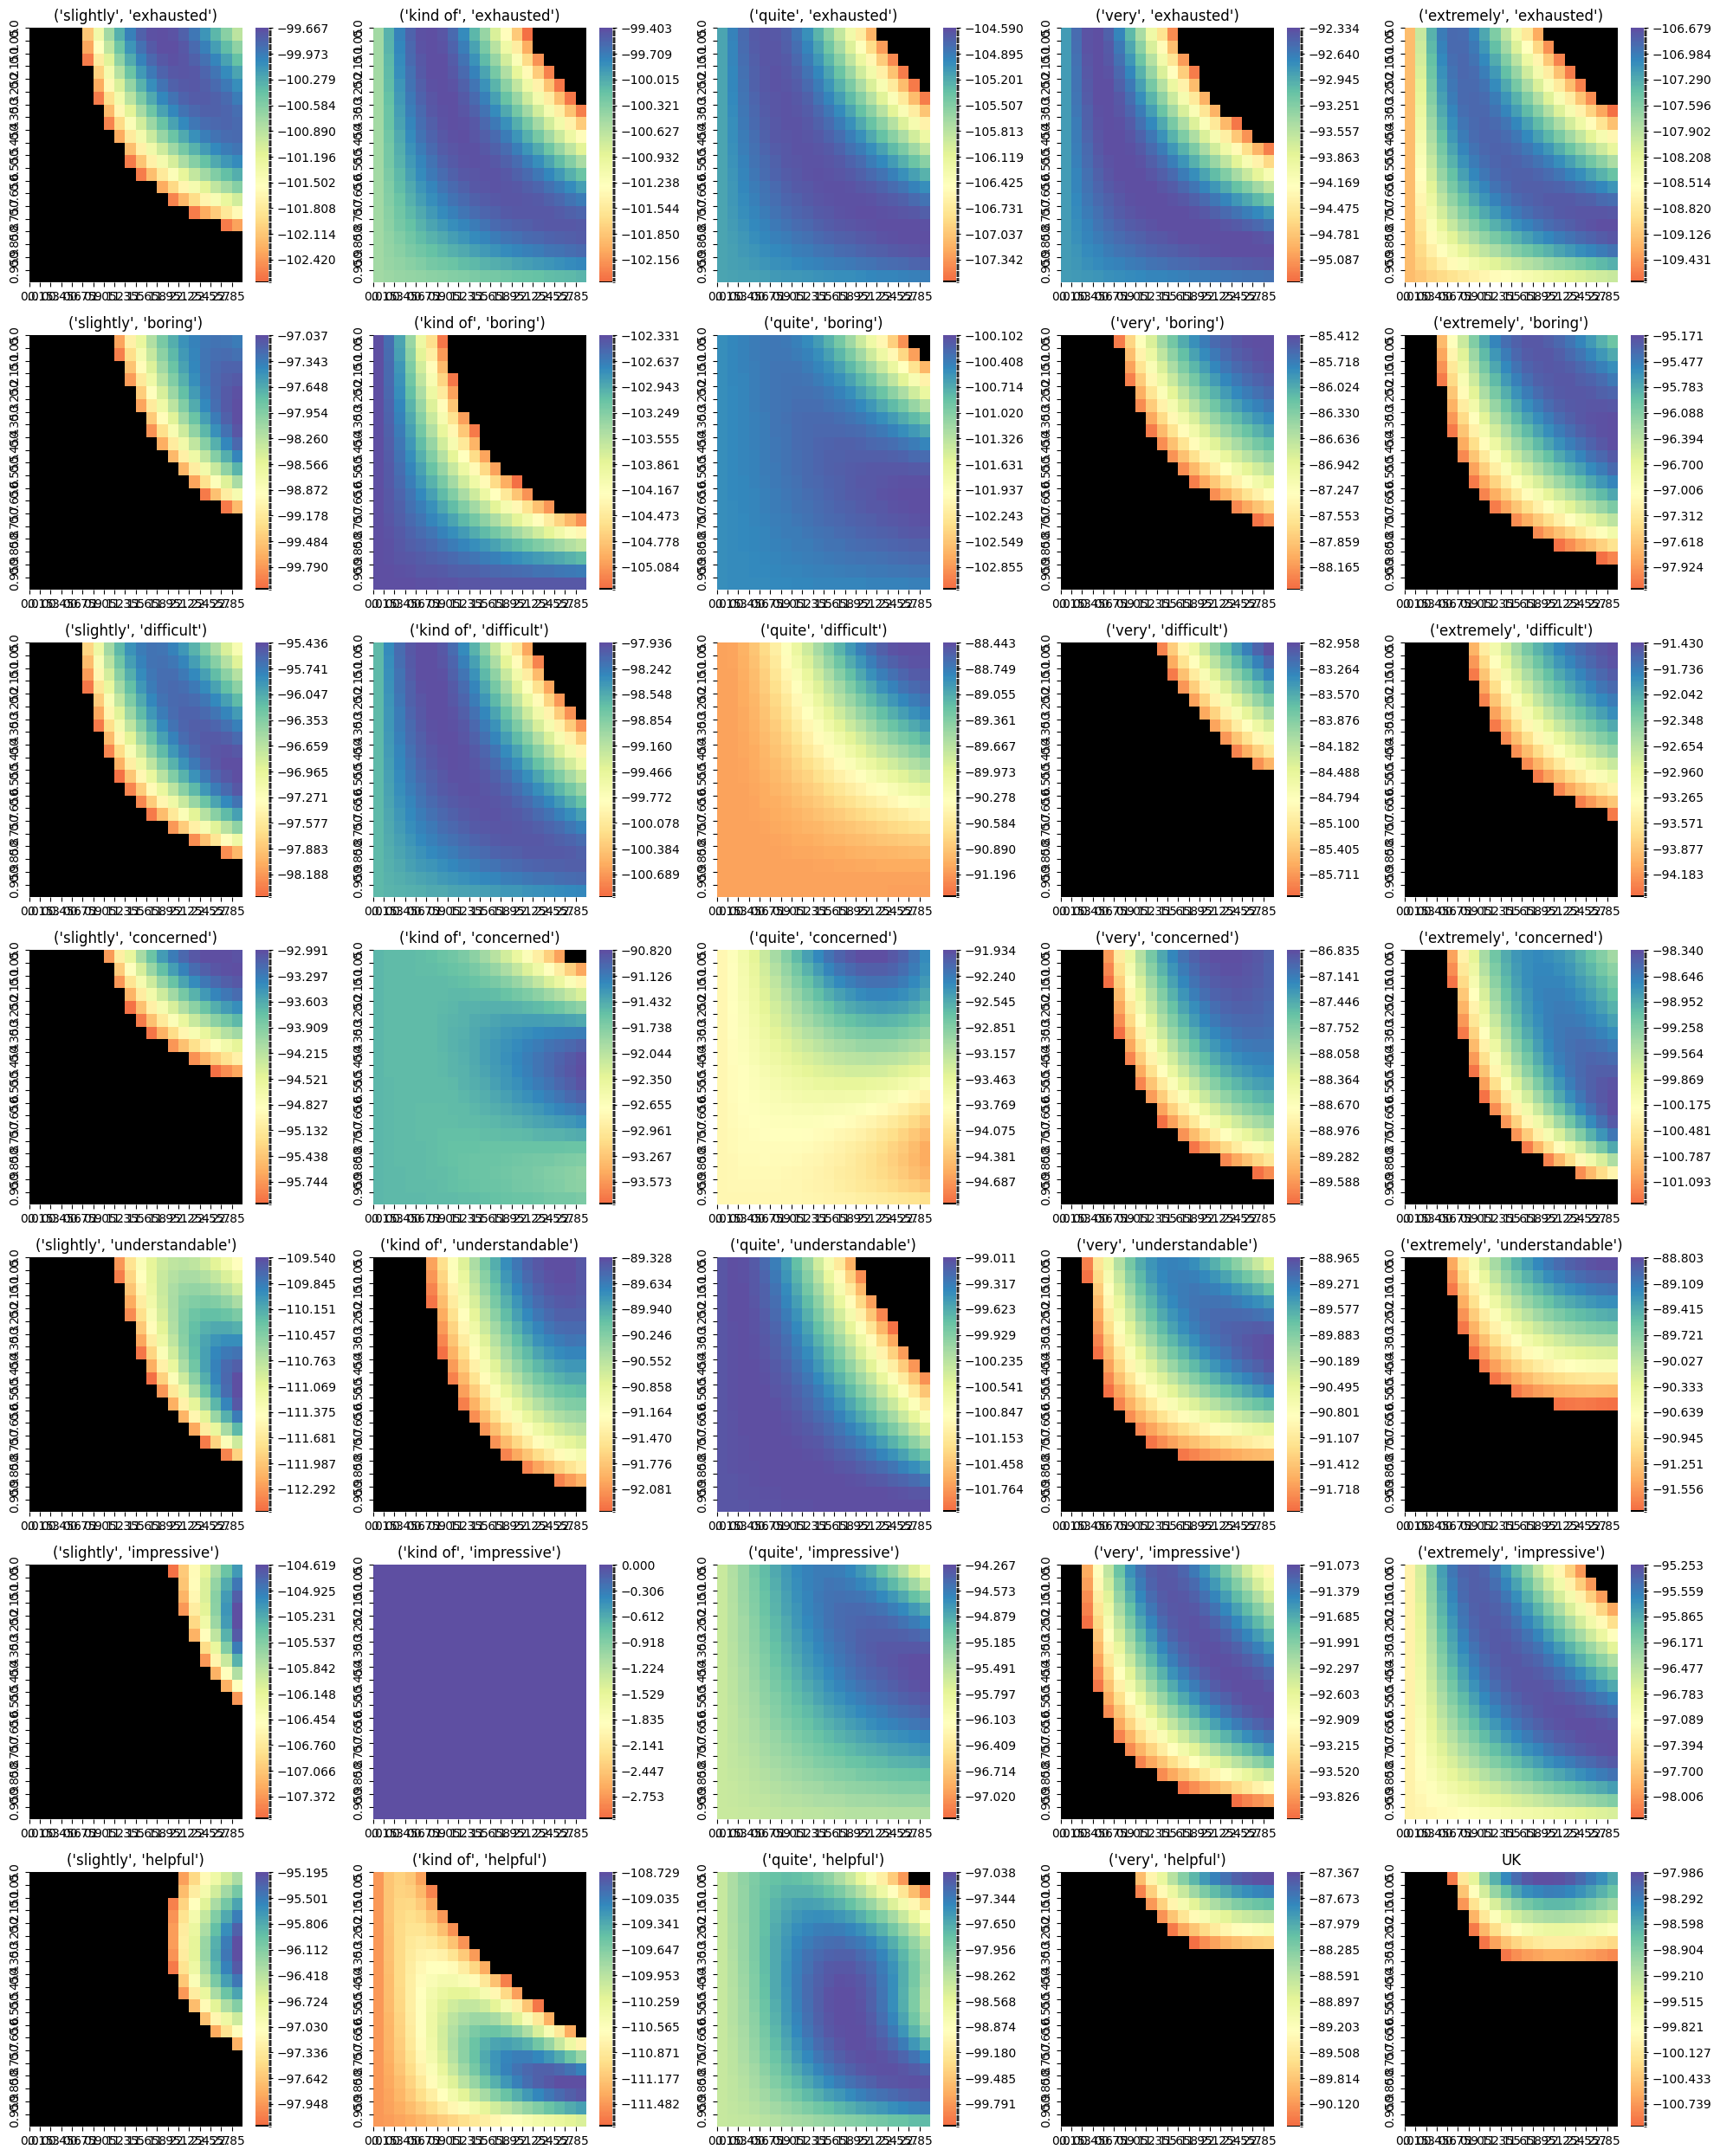

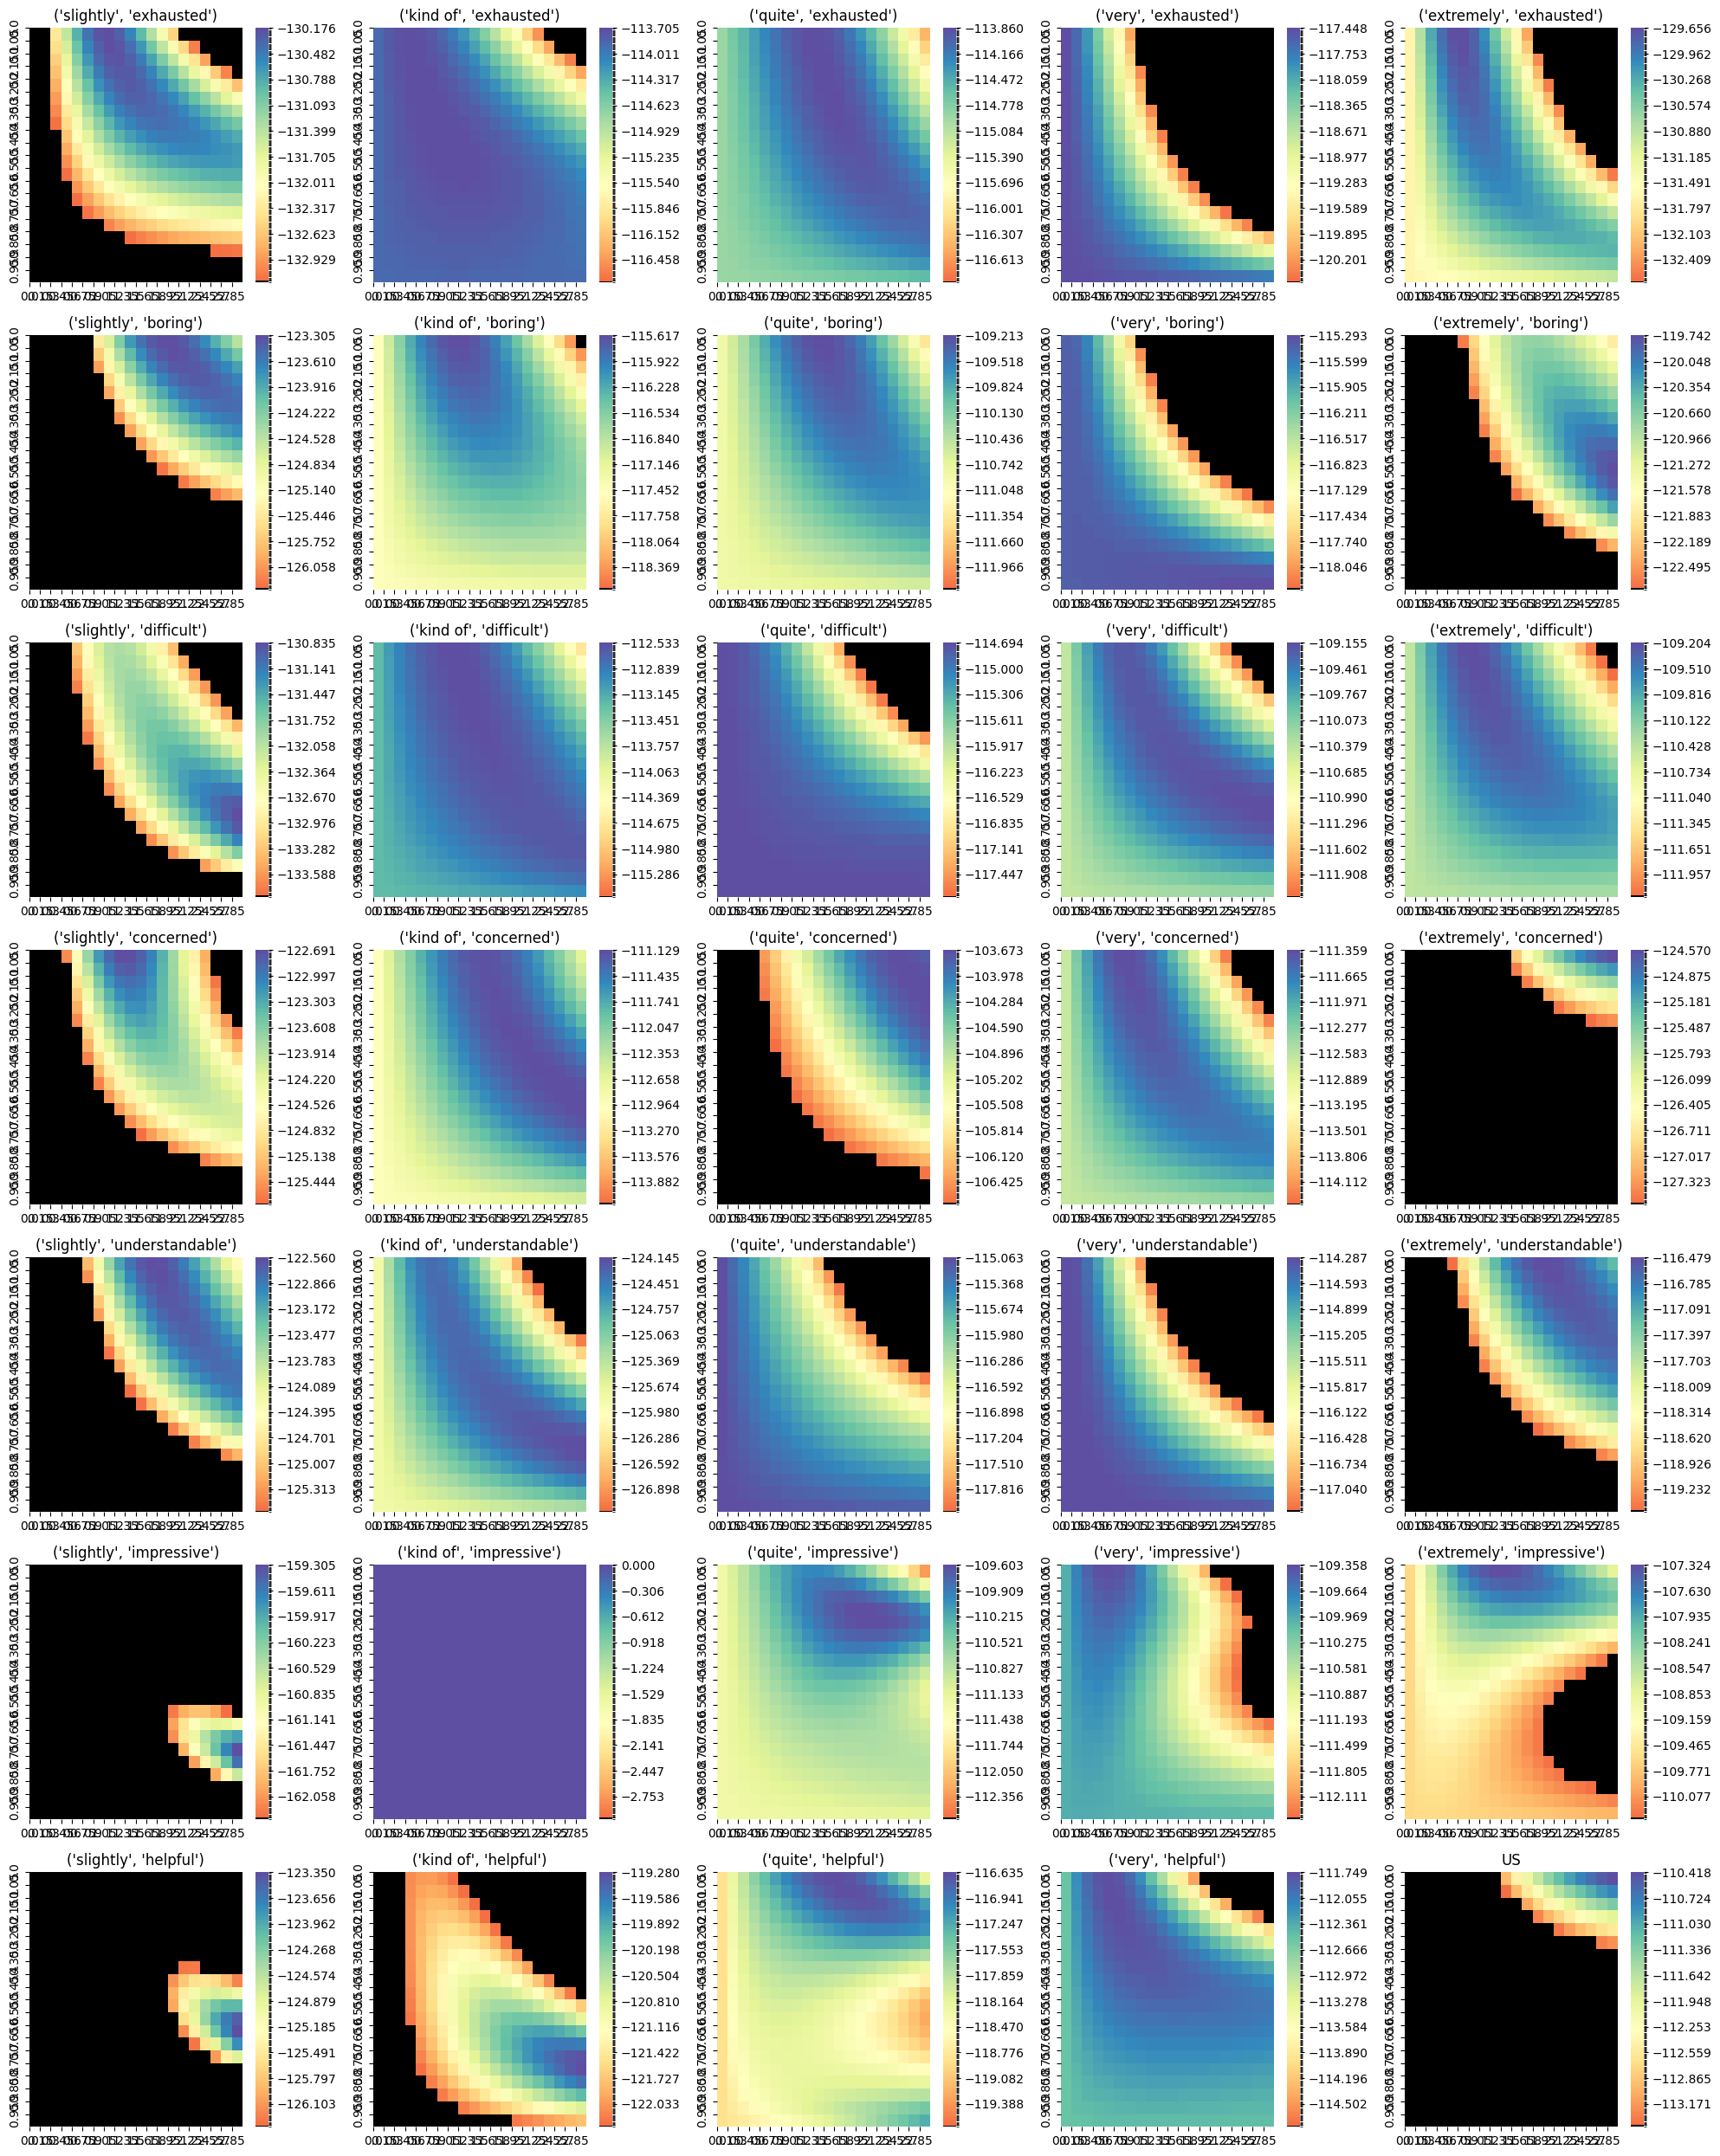

In [17]:
plot_heatmap(UK_specific_fit,'UK',possible_alpha,possible_phi)
plot_heatmap(US_specific_fit,'US',possible_alpha,possible_phi)

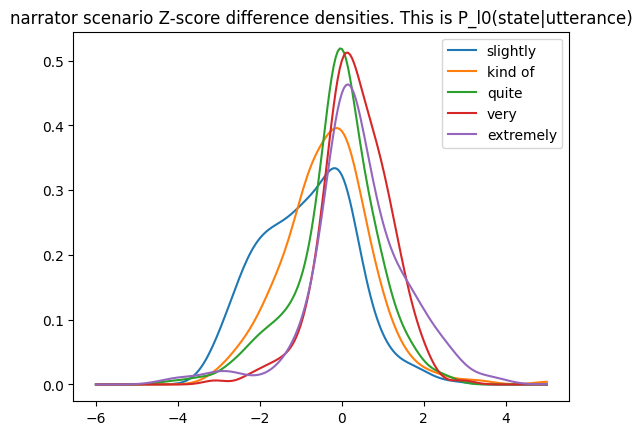

In [ ]:
import numpy as np
utterences =list(U_soc.keys())
predicates = list(set(w[1] for w in utterences))
intensifiers = list(set(w[0] for w in utterences))
# states are -3 to 3 with step size of 0.05
states = np.arange(-6, 5.05, 0.05)
new_U_inf = dict()
possible_phi = np.arange(0,1,0.05)
possible_alpha = np.arange(0,3,0.15)
for utterence in narrator['intensifier'].unique():
    data = narrator[narrator['intensifier'] == utterence]['Z-Score Difference']
    kde = gaussian_kde(data)
    densities_at_new_point = kde(states)  # This is the density at the new point
    # below is same as marginalizing so adds up to 1
    # plot kde as graph

    plt.plot(states, densities_at_new_point, label=utterence)
    # plot barplot of data
    new_U_inf[utterence] = np.log(densities_at_new_point)-np.log(np.sum(densities_at_new_point))
plt.legend()
plt.title('narrator scenario Z-score difference densities. This is P_l0(state|utterance)')
def new_P_state(s):
    # prior over states, but subject to change
    # return a gaussian with mean 0 std 1
    return (1/np.sqrt(2*np.pi))*np.exp(-((s-0)**2)/(2*1**2))
def new_U_s1(w,s,phi):
    # corresponds to U_s1(w) in the paper
    return phi*U_soc[w] + (1-phi)*new_U_inf[w[0]][int(s*20)+120]
# s spans from -100 to 100
new_P_s1 = dict() # corresponds to P_S1(w|s,phi)
for alpha in possible_alpha:
    for phi in possible_phi:
        for s in states:
            # marginalized over all utterences with same predicate ('slightly' 'kind of' 'quite' 'very' 'extremely')
            for pred in predicates:
                new_P_s1[(alpha,phi,s,pred)] = softmax([ alpha*new_U_s1((w,pred),s,phi) for w in intensifiers])
# only thing left is computing P_l1
new_P_l1 = dict()# corresponds to P_L1(s|w,phi)
for alpha in possible_alpha:
    for phi in possible_phi:
        for i in range(len(intensifiers)):
            for pred in predicates:
                w = intensifiers[i]
                new_P_l1[(alpha,phi,(w,pred))] = [new_P_s1[(alpha,phi,s,pred)][i]*new_P_state(s) for s in states]
                # normalize so adds up to 1
                new_P_l1[(alpha,phi,(w,pred))] = new_P_l1[(alpha,phi,(w,pred))]/np.sum(new_P_l1[(alpha,phi,(w,pred))])
test_fit(dialogue,new_P_l1)

C:\Users\myuhk\AppData\Local\Temp\ipykernel_33316\3635587199.py:21: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w)][int(s*20)+120]) for s in measured_values)


person_id             5e4edb7e14f95b000dd563d9
country                                     US
intensifier                           slightly
predicate                           impressive
response                                    31
rt                                       11874
has intensifier?                           yes
difference                               -53.0
Z-Score                              -5.355893
std                                   9.454712
Z-Score Difference                   -5.605671
scenario_type                         dialogue
scenario_country                   dialogue US
Name: 322, dtype: object 27


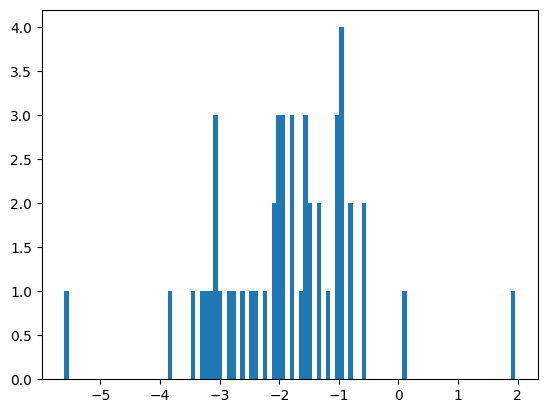

-29.48545864352446
person_id             5e4edb7e14f95b000dd563d9
country                                     US
intensifier                           slightly
predicate                           impressive
response                                    31
rt                                       11874
has intensifier?                           yes
difference                               -53.0
Z-Score                              -5.355893
std                                   9.454712
Z-Score Difference                   -5.605671
scenario_type                         dialogue
scenario_country                   dialogue US
Name: 322, dtype: object 4


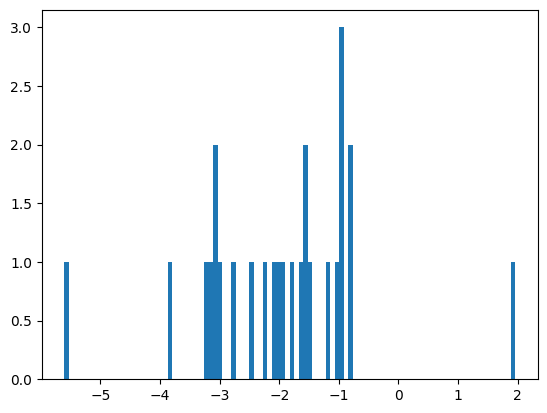

-29.48545864352446


In [255]:
def new_test_fit(data,P_l1):
    # test fit of model, P_l1 with data
    fit_judgement=dict()    
    for w in utterences:
        fit_judgement[w] = np.zeros((len(possible_phi),len(possible_alpha)))
        measured_values = data[((data['intensifier'] == w[0]) & (data['predicate'] == w[1]))]['Z-Score Difference'].values
        # print minimum of measured values
        if measured_values.size> 0:

            if np.min(measured_values) < -5:
                # get min value index
                min_index = np.argmin(measured_values)
                print(data[((data['intensifier'] == w[0]) & (data['predicate'] == w[1]))].iloc[min_index],min_index)
                plt.hist(measured_values, bins=100)
                plt.show()
                print(np.log(P_l1[(possible_alpha[7],0.2,w)][int(measured_values[min_index]*20)+120]))
            if np.max(measured_values) > 5:
                print(np.max(measured_values))
        for i in range(len(possible_phi)):
            for j in range(len(possible_alpha)):
                fit_judgement[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w)][int(s*20)+120]) for s in measured_values)
    return fit_judgement
new_fit_judgement = new_test_fit(dialogue,new_P_l1)
new_UK_fit_judgement = new_test_fit(dataframes[0],new_P_l1)
new_US_fit_judgement = new_test_fit(dataframes[3],new_P_l1)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
# Define a custom colormap
def plot_heatmap(data,title, possible_alpha, possible_phi):
    # Create a custom colormap that transitions from black to the base colormap
    base_cmap = sns.color_palette("Spectral", as_cmap=True)  # Base colormap
    colors = ["black"] + list(base_cmap(np.linspace(0.2, 1, 256)))  # Add black for below threshold
    custom_cmap = ListedColormap(colors)
    rows, cols = len(predicates),len(intensifiers)
    # Create subplots
    _, axes = plt.subplots(rows, cols, figsize=(20, 25))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        maximum = np.max(data[utterences[i]])
        bounds = [-10000, maximum-3] + list(np.linspace(maximum-3, maximum, 256))
        norm = BoundaryNorm(bounds, len(bounds) - 1)
        sns.heatmap(data[utterences[i]],ax=ax, cmap=custom_cmap, norm=norm, cbar=True)
        ax.set_title(f"{utterences[i]}")
        # label x and y by the possible values
        ax.set_xticks(range(len(possible_alpha)), [round(x, 2) for x in possible_alpha])
        ax.set_yticks(range(len(possible_phi)), [round(x, 2) for x in possible_phi])
        # rotate y ticks by 90
        ax.set_yticklabels(ax.get_yticklabels(), rotation=90)

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.title(title)
    # Show the plots
    plt.show()
plot_heatmap(new_UK_fit_judgement,'UK',possible_alpha,possible_phi)
plot_heatmap(new_US_fit_judgement,'US',possible_alpha,possible_phi)


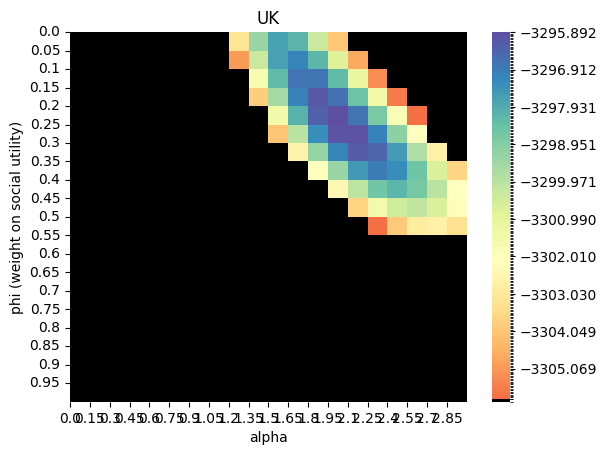

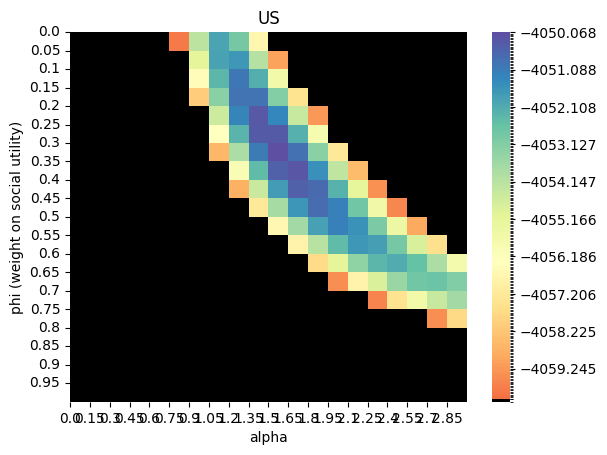

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
# Define a custom colormap
base_cmap = sns.color_palette("Spectral", as_cmap=True)  # Base colormap
colors = ["black"] + list(base_cmap(np.linspace(0.2, 1, 256)))  # Add black for below threshold
custom_cmap = ListedColormap(colors)

def plot_fits(fit_judgement, possible_alpha, possible_phi,title,minus_thresh):
    # Define a normalization function
    threshold = np.max(np.sum([fit_judgement[w] for w in utterences],axis=0))+minus_thresh
    bounds = [-10000, threshold] + list(np.linspace(threshold, np.max(np.sum([fit_judgement[w] for w in utterences],axis=0)), 256))
    norm = BoundaryNorm(bounds, len(bounds) - 1)
    sns.heatmap(np.sum([fit_judgement[w] for w in utterences],axis=0), cmap=custom_cmap, norm=norm, cbar=True)# label x and y by the possible values
    plt.xticks(range(len(possible_alpha)), [round(x, 2) for x in possible_alpha])
    plt.yticks(range(len(possible_phi)), [round(x, 2) for x in possible_phi])
    # label x and y axis
    plt.xlabel('alpha')
    plt.ylabel('phi (weight on social utility)')
    # rotate y ticks by 90
    plt.yticks(rotation=0)
    # label colors in heatmap
    plt.title(title)
    # plt.colorbar()
    plt.show()
plot_fits(UK_specific_fit,possible_alpha,possible_phi,'UK',-10)
plot_fits(US_specific_fit,possible_alpha,possible_phi,'US',-10)

# plot_fits(new_UK_fit_judgement,possible_alpha,possible_phi,'UK',-10)
# plot_fits(new_US_fit_judgement,possible_alpha,possible_phi,'US',-10)
# # plot both
# plot_fits(new_fit_judgement,possible_alpha,possible_phi,'Both',-20)
# # print best fit for US and UK
# print(f"US best fit: {np.unravel_index(np.argmax(np.sum([new_US_fit_judgement[w] for w in utterences],axis=0), axis=None), np.sum([new_US_fit_judgement[w] for w in utterences],axis=0).shape)}")
# print(f"UK best fit: {np.unravel_index(np.argmax(np.sum([new_UK_fit_judgement[w] for w in utterences],axis=0), axis=None), np.sum([new_UK_fit_judgement[w] for w in utterences],axis=0).shape)}")
# print(f"best fit: {np.unravel_index(np.argmax(np.sum([new_fit_judgement[w] for w in utterences],axis=0), axis=None), np.sum([new_fit_judgement[w] for w in utterences],axis=0).shape)}")

In [16]:
print(f"UK best fit: {np.unravel_index(np.argmax(np.sum([UK_specific_fit[w] for w in utterences],axis=0), axis=None), np.sum([UK_specific_fit[w] for w in utterences],axis=0).shape)}")
print(f"US best fit: {np.unravel_index(np.argmax(np.sum([US_specific_fit[w] for w in utterences],axis=0), axis=None), np.sum([US_specific_fit[w] for w in utterences],axis=0).shape)}")

UK best fit: (4, 13)
US best fit: (6, 10)


## Another computational model including non-modifier, and cost function
- in order to consider non-modifier scenarios, we cant's use non-modifiers as baseline to subtract with-modifier scenarios from. Instead, we use averages of each predicate within each person as the baseline, and compute probabilities from that

In [ ]:
UK_dialogue['predicate Z-score'] = UK_dialogue.groupby(['person_id','predicate'])['response'].transform(lambda x: (x - x.mean()) / x.std())
US_dialogue['predicate Z-score'] = US_dialogue.groupby(['person_id','predicate'])['response'].transform(lambda x: (x - x.mean()) / x.std())
UK_politeness['predicate Z-score'] = UK_politeness.groupby(['person_id','predicate'])['response'].transform(lambda x: (x - x.mean()) / x.std())

Unnamed: 0                 person_id country intensifier  predicate  \
0              0  5920b86a53cb680001205632      UK    slightly  exhausted   
1              1  5920b86a53cb680001205632      UK    slightly  exhausted   
2              2  5920b86a53cb680001205632      UK     kind of  exhausted   
3              3  5920b86a53cb680001205632      UK     kind of  exhausted   
4              4  5920b86a53cb680001205632      UK       quite  exhausted   
...          ...                       ...     ...         ...        ...   
1559        1559  67190154967c9ff4ba3b8f55      UK       quite    helpful   
1560        1560  67190154967c9ff4ba3b8f55      UK        very    helpful   
1561        1561  67190154967c9ff4ba3b8f55      UK        very    helpful   
1562        1562  67190154967c9ff4ba3b8f55      UK   extremely    helpful   
1563        1563  67190154967c9ff4ba3b8f55      UK   extremely    helpful   

      response     rt has intensifier?  difference   Z-Score        std  \
0           70  14479              yes        -7.0 -0.356888  19.261702   
1           77  12584               no         NaN  0.009230  19.261702   
2           67  10753              yes        -5.0 -0.513795  19.261702   
3           72   6685               no         NaN -0.252283  19.261702   
4           68   8484              yes       -31.0 -0.461493  19.261702   
...        ...    ...              ...         ...       ...        ...   
1559         0  15860               no         NaN -0.836660  49.581214   
1560         0  13412              yes         0.0 -0.836660  49.581214   
1561         0   7570               no         NaN -0.836660  49.581214   
1562       100  26452              yes       100.0  1.195229  49.581214   
1563         0  14736               no         NaN -0.836660  49.581214   

      Z-Score Difference scenario_type scenario_country  predicate Z-score  
0              -0.363415      dialogue      dialogue UK           0.133356  
1                    NaN      dialogue      dialogue UK           0.323865  
2              -0.259582      dialogue      dialogue UK           0.051710  
3                    NaN      dialogue      dialogue UK           0.187787  
4              -1.609411      dialogue      dialogue UK           0.078925  
...                  ...           ...              ...                ...  
1559                 NaN      dialogue      dialogue UK          -0.474342  
1560            0.000000      dialogue      dialogue UK          -0.474342  
1561                 NaN      dialogue      dialogue UK          -0.474342  
1562            2.016893      dialogue      dialogue UK           1.897367  
1563                 NaN      dialogue      dialogue UK          -0.474342  

[1564 rows x 15 columns]

In [193]:
# Read UK_df.csv as pandas dataframe
UK_dialogue = pd.read_csv('UK_df.csv')
UK_politeness = pd.read_csv('UK_direct_df.csv')
UK_narrator = pd.read_csv('UK_narrator_df.csv')
US_dialogue = pd.read_csv('US_df.csv')
US_politeness = pd.read_csv('US_direct_df.csv')
US_narrator = pd.read_csv('US_narrator_df.csv')
dataframes = [UK_dialogue, UK_politeness, UK_narrator, US_dialogue, US_politeness, US_narrator]
def elim_outliers(df):
    # dropped Unnamed: 0 column
    df.drop(columns=['Unnamed: 0'], inplace=True)
    filtered_df = df.loc[(df['response'] > 95) | (df['response'] < 5)]
    for id in df['person_id'].unique():
        if len(filtered_df[filtered_df['person_id'] == id])/len(df[df['person_id'] == id])>0.8:
            df.drop(df[df['person_id'] == id].index, inplace=True)
    df['predicate Z-score'] = df.groupby(['person_id','predicate'])['response'].transform(lambda x: (x - x.mean()) / x.std())
    # if has_intensifier = no then change 'intensifier' to 'none'
    df.loc[df['has intensifier?'] == 'no', 'intensifier'] = 'none'
    return df
for i in range(len(dataframes)):
    dataframes[i] = elim_outliers(dataframes[i])
politeness = pd.concat([dataframes[1], dataframes[4]])
narrator = pd.concat([dataframes[2], dataframes[5]])
UK_narrator = dataframes[2]
US_narrator = dataframes[5]
dialogue = pd.concat([dataframes[0], dataframes[3]])

In [ ]:
# compute U_soc by getting mean of predicate Z-score for each intensifier and predicate
U_soc_pred = politeness.groupby(['intensifier','predicate'])['predicate Z-score'].mean().to_dict()
U_soc_dif = politeness.groupby(['intensifier','predicate'])['Z-Score Difference'].mean().to_dict()

{('extremely', 'boring'): -0.2725411733303405,
 ('extremely', 'concerned'): 0.023853581842512878,
 ('extremely', 'difficult'): -0.19280366411388355,
 ('extremely', 'exhausted'): 0.166499723126367,
 ('extremely', 'helpful'): 0.4018530921634451,
 ('extremely', 'impressive'): 0.35616280342212664,
 ('extremely', 'understandable'): 0.18472467676418425,
 ('kind of', 'boring'): -0.36202496443658355,
 ('kind of', 'concerned'): 0.030779947399467666,
 ('kind of', 'difficult'): 0.2948364810601392,
 ('kind of', 'exhausted'): 0.010877796500843546,
 ('kind of', 'helpful'): -0.9911198725440248,
 ('kind of', 'impressive'): -0.2379452943815439,
 ('kind of', 'understandable'): -0.04236477207071975,
 ('none', 'boring'): -0.05570653174530521,
 ('none', 'concerned'): 0.08176224953057895,
 ('none', 'difficult'): -0.0004073546625390349,
 ('none', 'exhausted'): -0.0689858308985959,
 ('none', 'helpful'): 0.2714109430820988,
 ('none', 'impressive'): 0.26564336297840246,
 ('none', 'understandable'): 0.0398240433

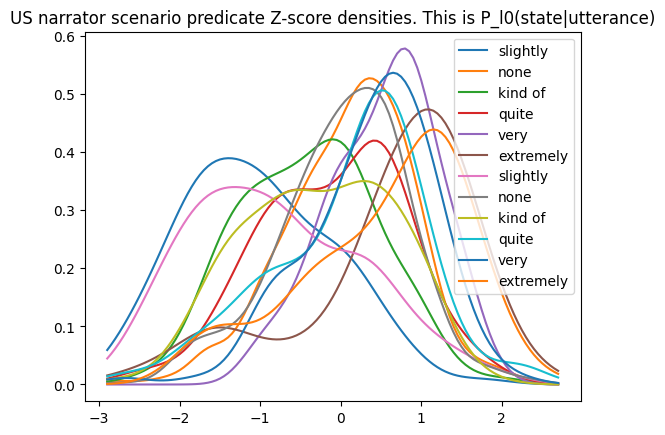

In [ ]:
import numpy as np
utterences =list(U_soc.keys())
predicates = list(set(w[1] for w in utterences))
intensifiers = list(set(w[0] for w in utterences))
costs = np.arange(0,1.6,0.1)
states = np.arange(-2.9, 2.75, 0.05)
S = np.min(states)
possible_phi = np.arange(0,1,0.05)
possible_alpha = np.arange(0,3,0.15)
UK_U_inf = construct_U_inf(UK_narrator,'Z-Score Difference','UK narrator scenario Z-score difference densities. This is P_l0(state|utterance)')
US_U_inf = construct_U_inf(US_narrator,'Z-Score Difference','US narrator scenario Z-score difference densities. This is P_l0(state|utterance)')
U_inf = construct_U_inf(narrator,'Z-Score Difference','narrator scenario Z-score difference densities. This is P_l0(state|utterance)')
UK_P_l1 = construct_P_l1(UK_U_inf,costs,possible_alpha,possible_phi,states,predicates,intensifiers)
US_P_l1 = construct_P_l1(US_U_inf,costs,possible_alpha,possible_phi,states,predicates,intensifiers)

In [87]:
# print min and max of dialogue['predicate Z-score'].values
print(np.min(dialogue['predicate Z-score'].values),np.max(dialogue['predicate Z-score'].values))

-2.7484648216783802 2.6870057685088806


In [196]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
costs = np.arange(0,1.6,0.1)
def test_fit(data,P_l1,cost):
    # test fit of model, P_l1 with data
    fit_judgement=dict()    
    for w in utterences:
        fit_judgement[w] = np.zeros((len(possible_phi),len(possible_alpha)))
        measured_values = data[((data['intensifier'] == w[0]) & (data['predicate'] == w[1]))]['predicate Z-score'].values
        # print minimum of measured values
        for i in range(len(possible_phi)):
            for j in range(len(possible_alpha)):
                fit_judgement[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w,cost)][int((s-S)*20)]) for s in measured_values)
    return fit_judgement



# plot subplots for cost in np.arange(0,1.6,0.1)

UK_judgements = []
for cost in costs:
    UK_judgements.append(test_fit(dataframes[0],UK_P_l1,cost))
US_judgements = []
for cost in costs:
    US_judgements.append(test_fit(dataframes[3],US_P_l1,cost))
# both_judgements = []   
# for cost in costs:
#     both_judgements.append(test_fit(dialogue,P_l1,cost))

C:\Users\myuhk\AppData\Local\Temp\ipykernel_12972\1811994100.py:15: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w,cost)][int((s-S)*20)]) for s in measured_values)


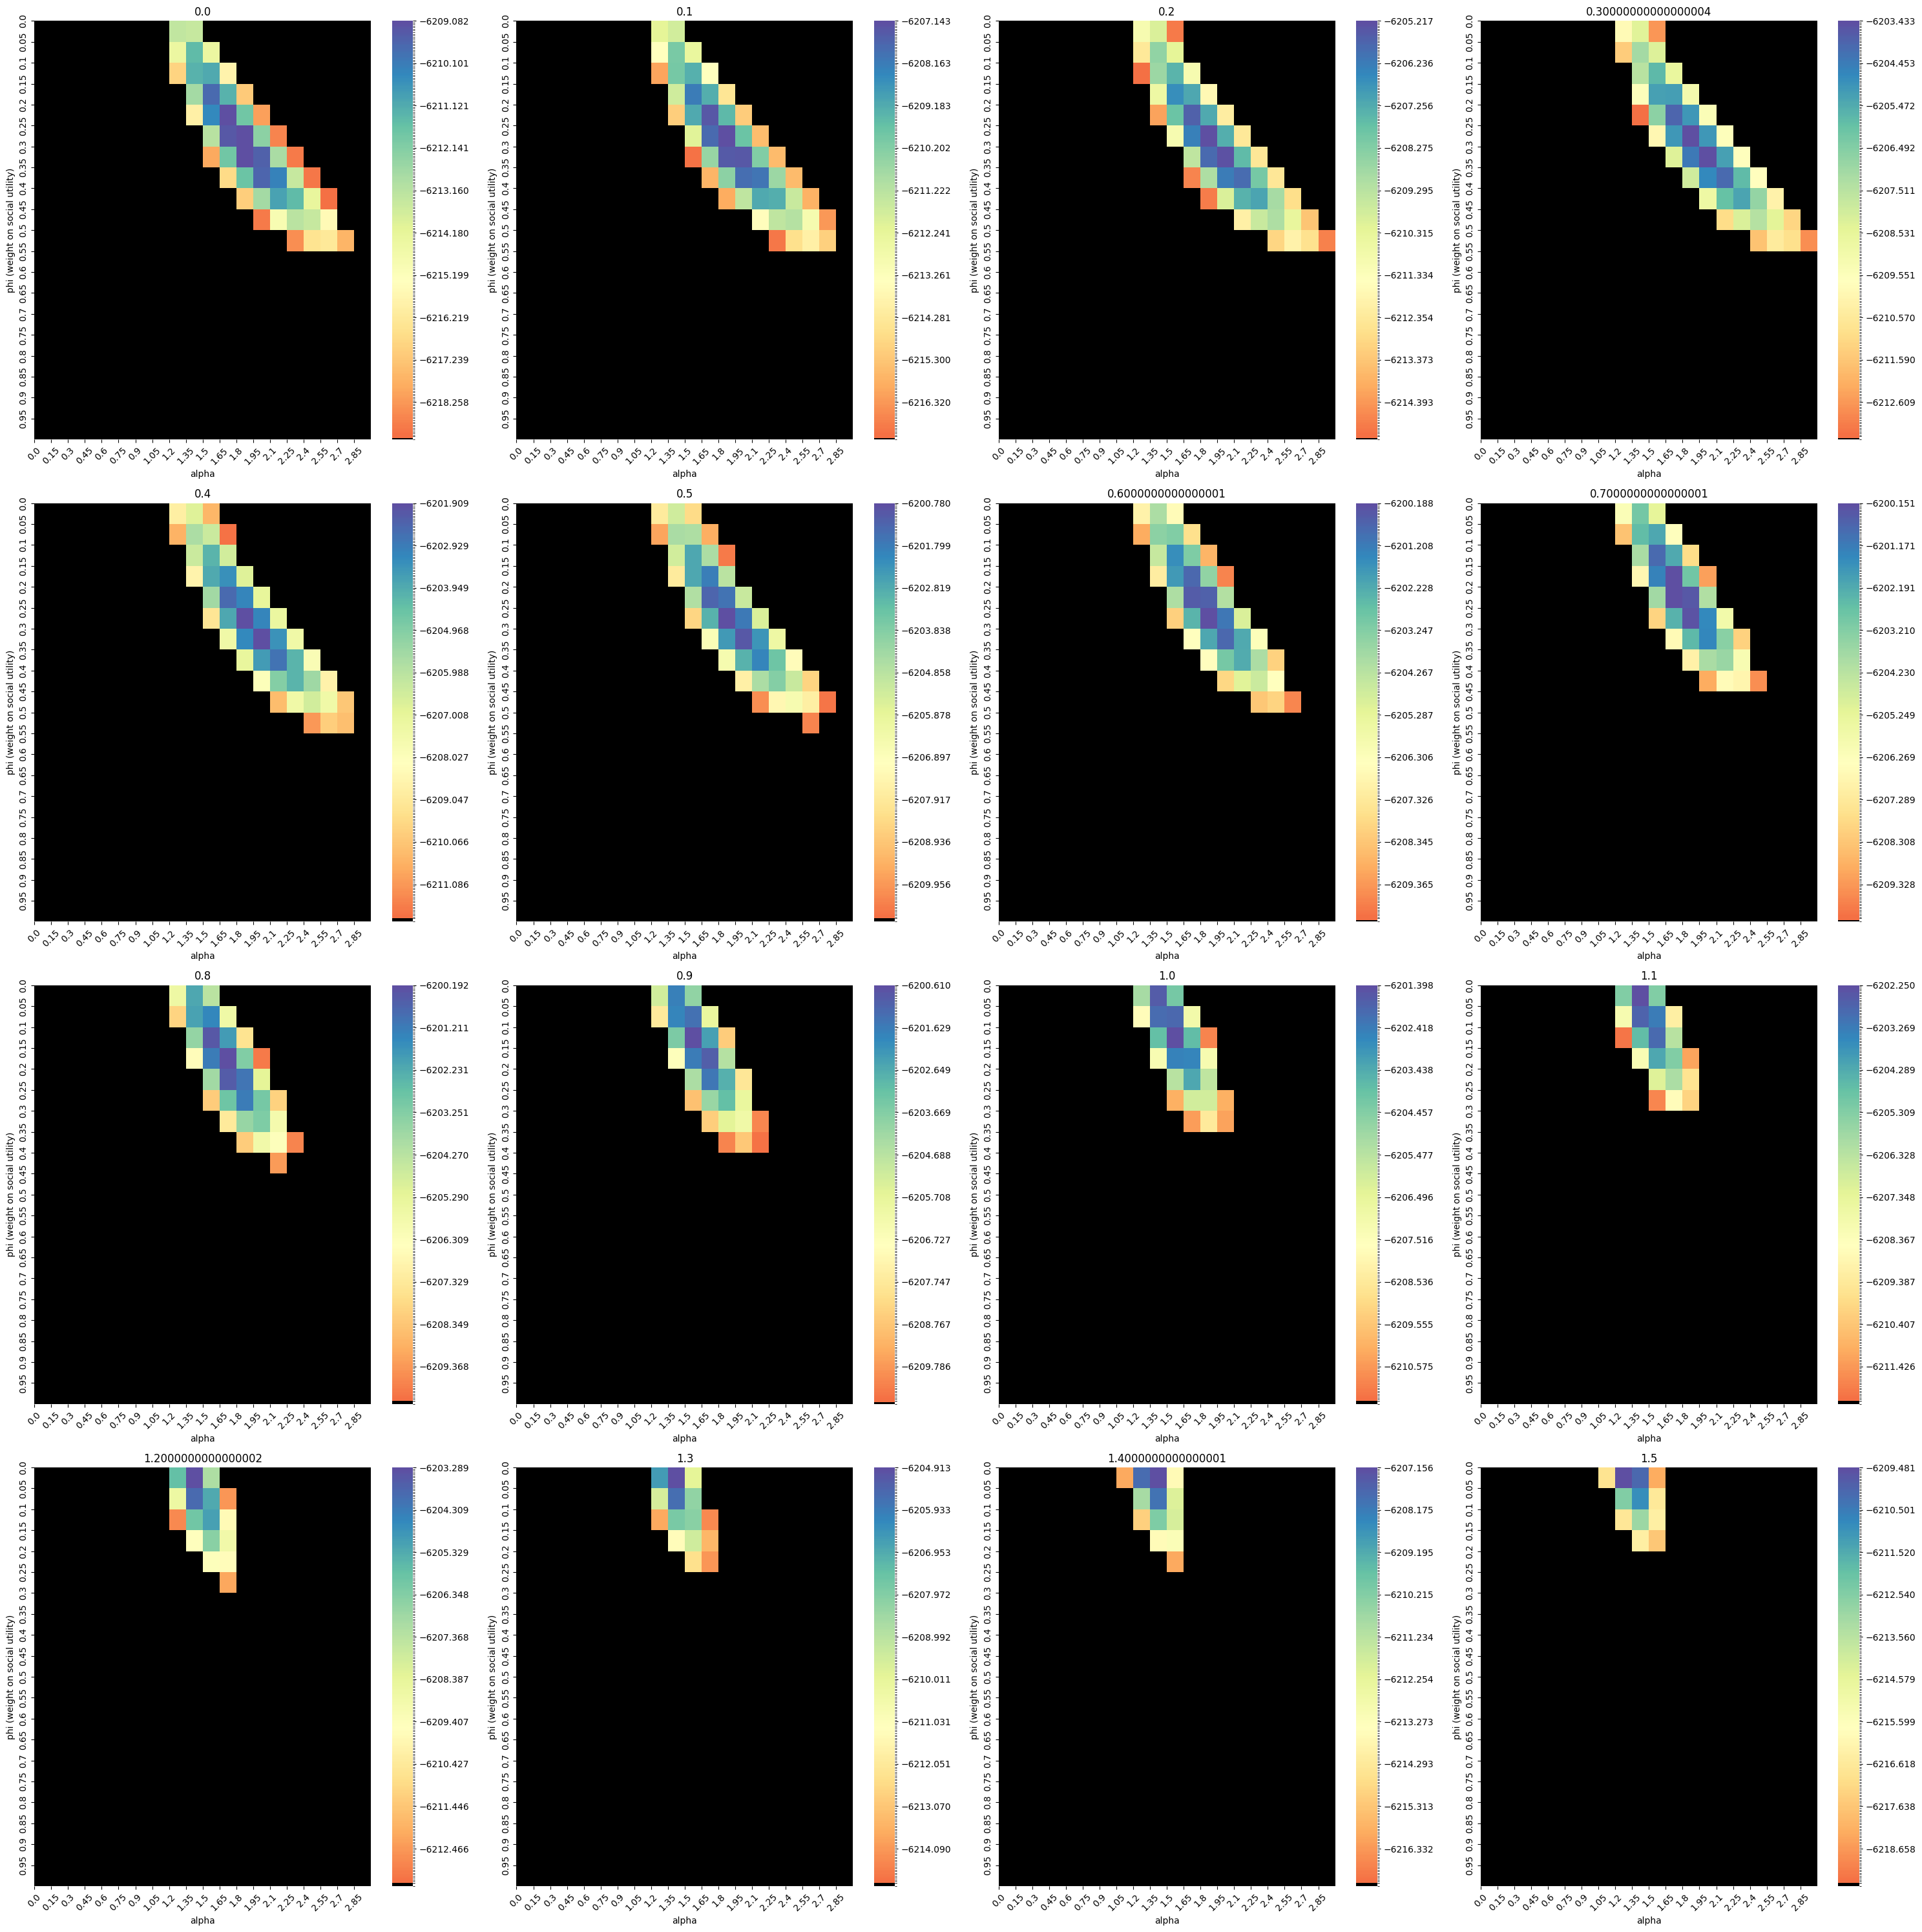

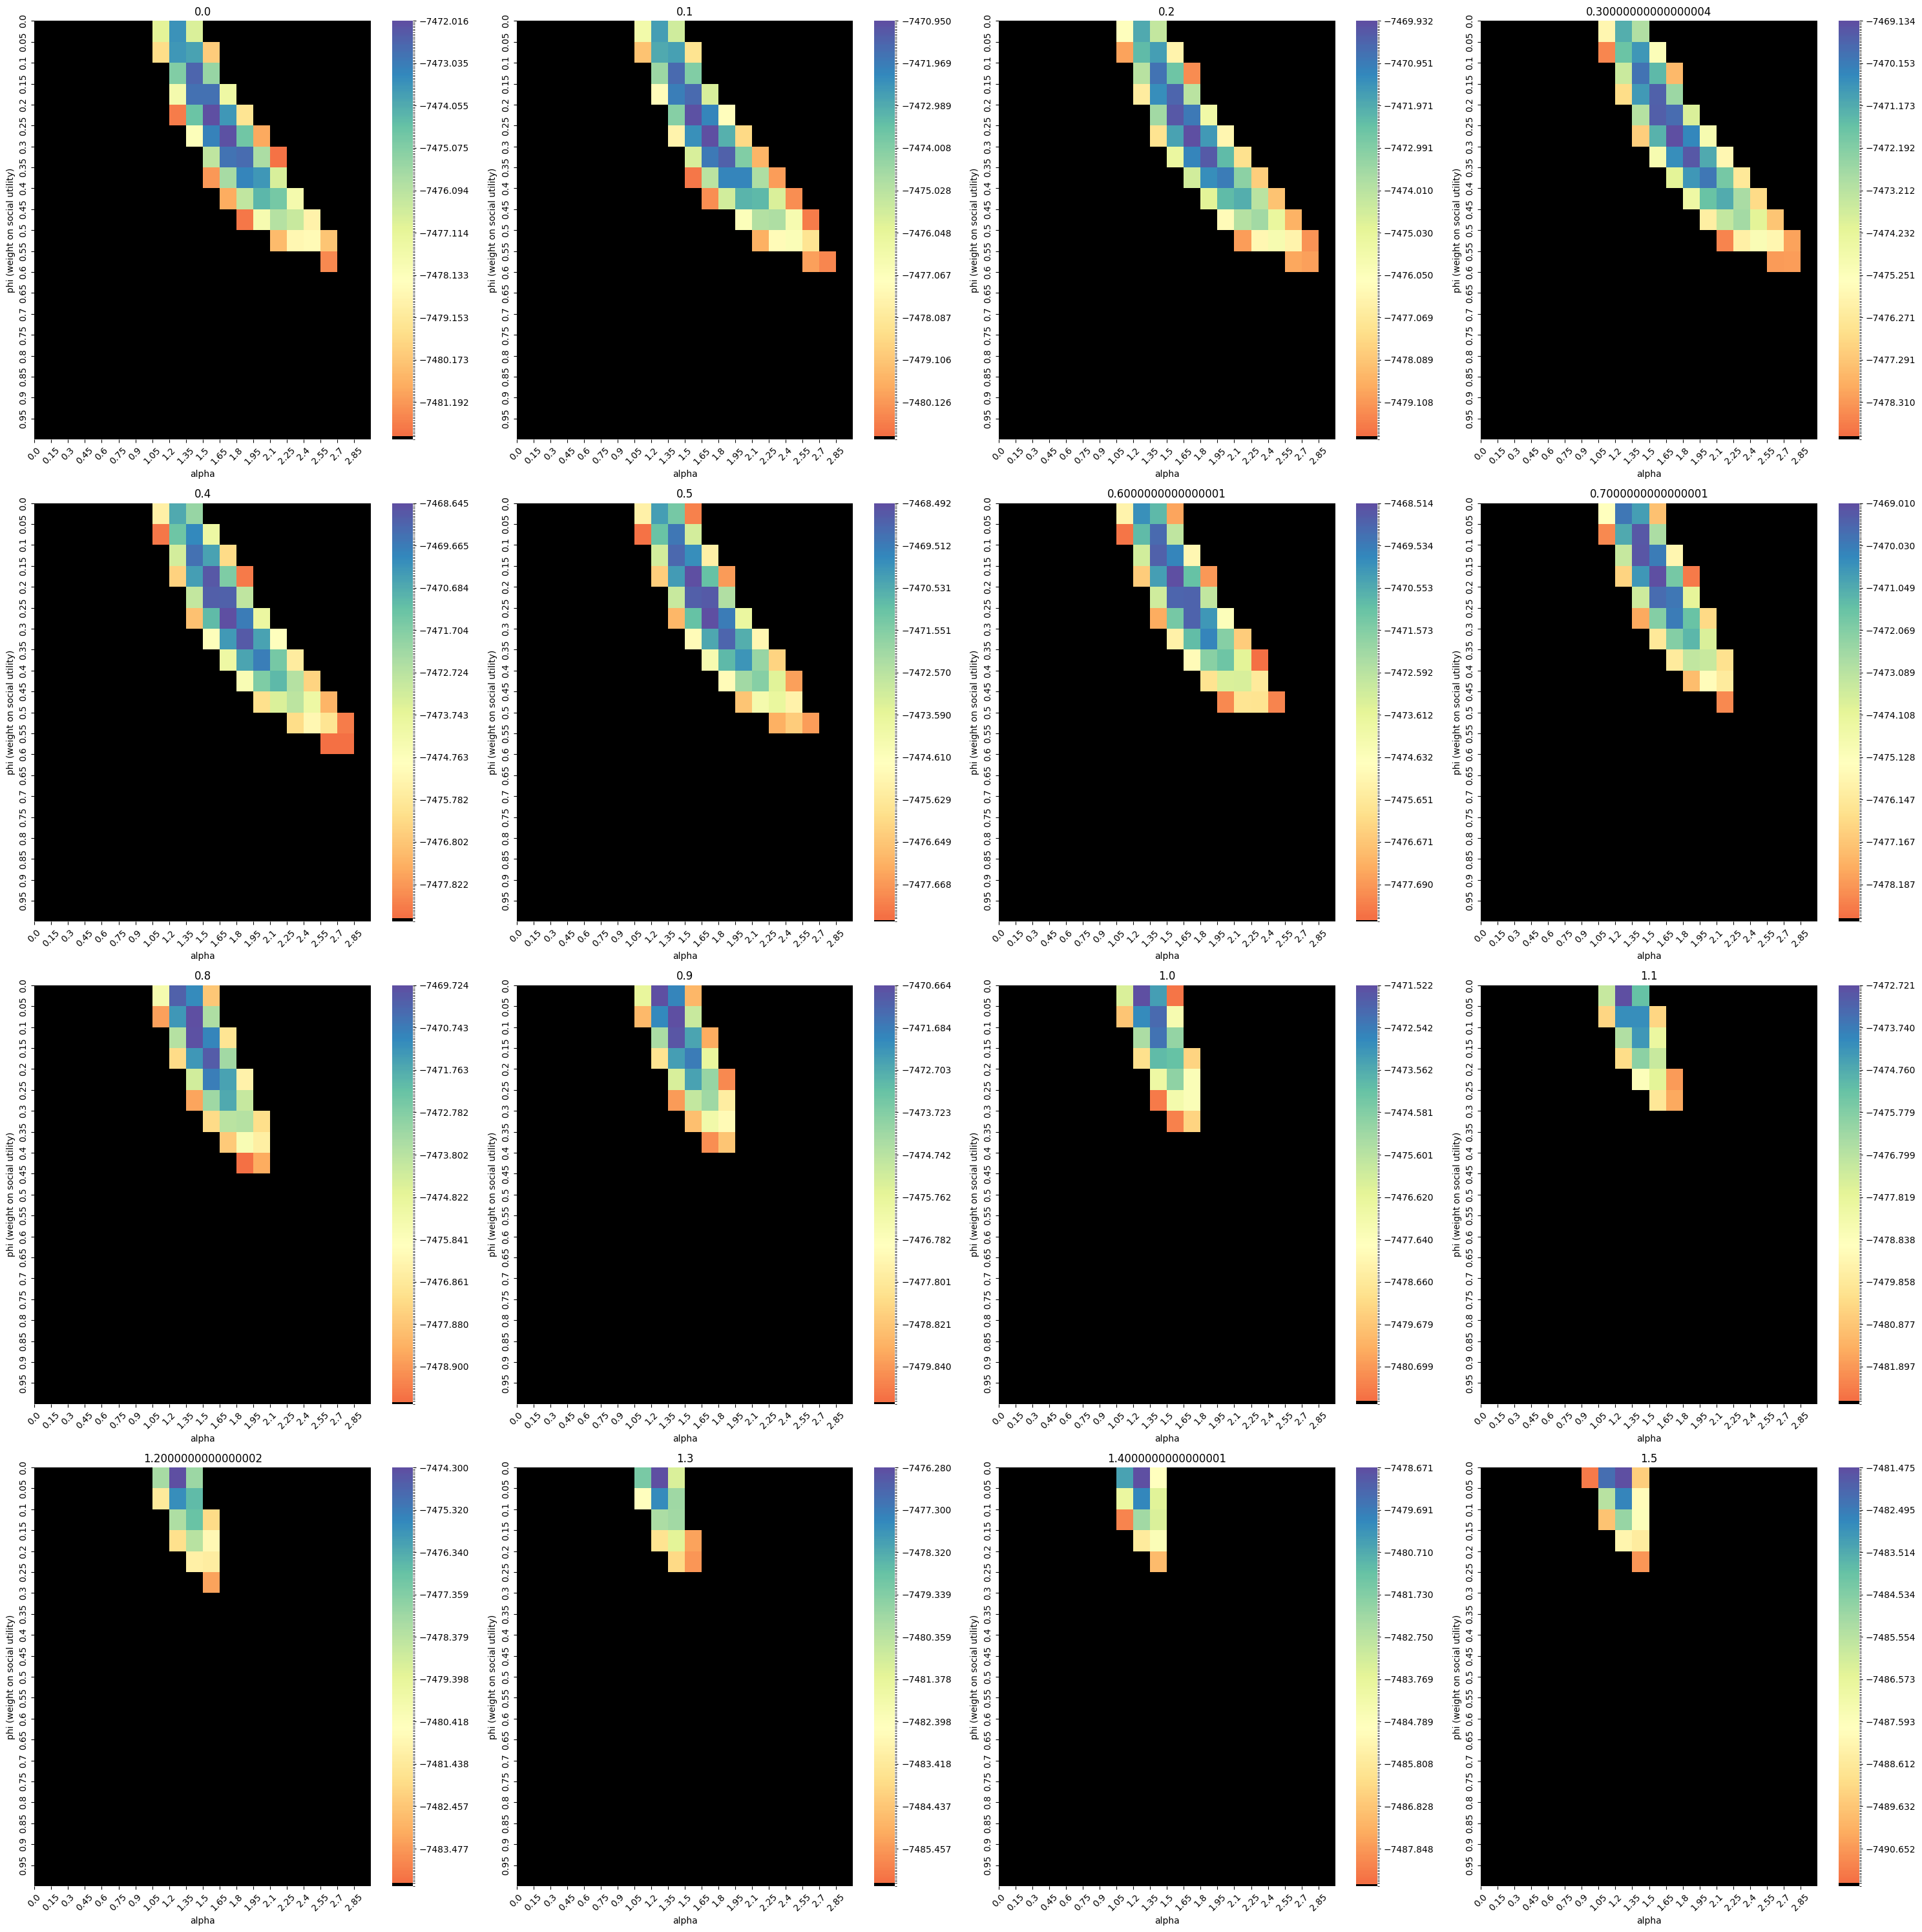

In [197]:
def cost_subplots(fit_judgements, possible_alpha, possible_phi,title):
    base_cmap = sns.color_palette("Spectral", as_cmap=True)  # Base colormap
    colors = ["black"] + list(base_cmap(np.linspace(0.2, 1, 256)))  # Add black for below threshold
    custom_cmap = ListedColormap(colors)
    # Create subplots
    _, axes = plt.subplots(4,4, figsize=(30,30))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        maximum = np.max(np.sum([fit_judgements[i][w] for w in utterences],axis=0))
        bounds = [-20000, maximum-10] + list(np.linspace(maximum-10, maximum, 256))
        norm = BoundaryNorm(bounds, len(bounds) - 1)
        sns.heatmap(np.sum([fit_judgements[i][w] for w in utterences],axis=0),ax=ax, cmap=custom_cmap, norm=norm, cbar=True)# label x and y by the possible values
        # label x and y axis
        ax.set_xlabel('alpha')
        ax.set_ylabel('phi (weight on social utility)')
    
    
        ax.set_title(f"{costs[i]}")
        # label x and y by the possible values
        ax.set_xticks(range(len(possible_alpha)), [round(x, 2) for x in possible_alpha])
        ax.set_yticks(range(len(possible_phi)), [round(x, 2) for x in possible_phi])
        # rotate y ticks by 90
        ax.set_yticklabels(ax.get_yticklabels(), rotation=90)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    # Show the plots
    plt.show()
# norm = BoundaryNorm(bounds, len(bounds) - 1)
#     sns.heatmap(np.sum([fit_judgement[w] for w in utterences],axis=0), cmap=custom_cmap, norm=norm, cbar=True)# label x and y by the possible values
#     plt.xticks(range(len(possible_alpha)), [round(x, 2) for x in possible_alpha])
#     plt.yticks(range(len(possible_phi)), [round(x, 2) for x in possible_phi])
#     # label x and y axis
#     plt.xlabel('alpha')
#     plt.ylabel('phi (weight on social utility)')
#     # rotate y ticks by 90
#     plt.xticks(rotation=45)
#     # label colors in heatmap
#     plt.title(title)
#     # plt.colorbar()
#     plt.show()

cost_subplots(UK_judgements,possible_alpha,possible_phi,'UK')
cost_subplots(US_judgements,possible_alpha,possible_phi,'US')
# cost_subplots(both_judgements,possible_alpha,possible_phi,'Both')

C:\Users\myuhk\AppData\Local\Temp\ipykernel_12972\3123264684.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w,cost)][int((s-S)*20)]) for s in measured_values)


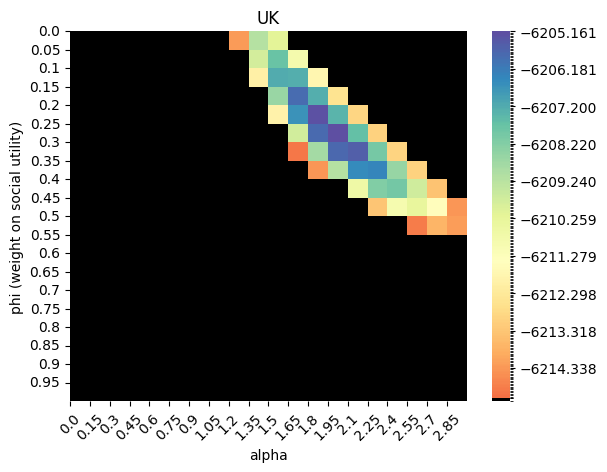

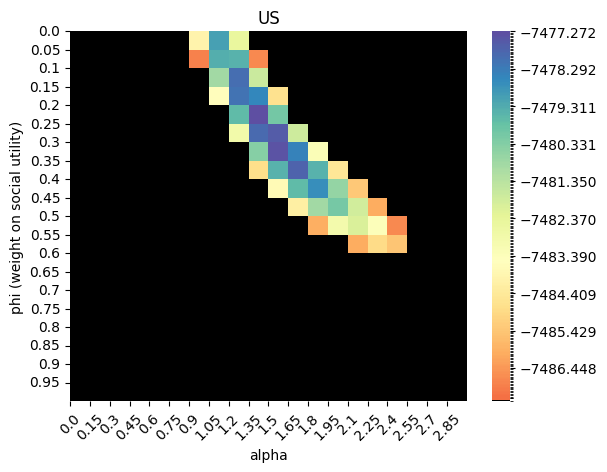

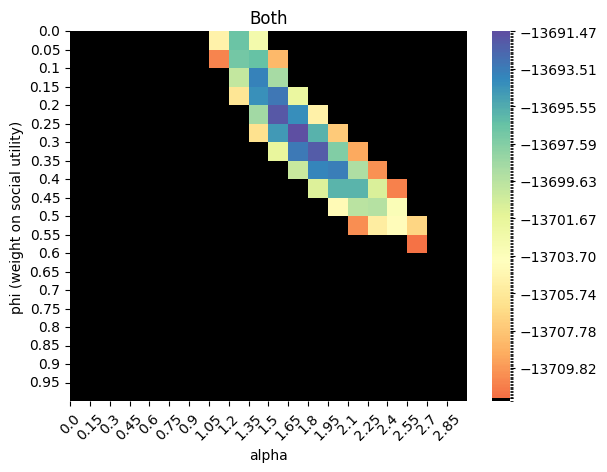

US best fit: (4, 9)
UK best fit: (5, 13)
best fit: (5, 11)
cost: 0.0


C:\Users\myuhk\AppData\Local\Temp\ipykernel_12972\3123264684.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w,cost)][int((s-S)*20)]) for s in measured_values)


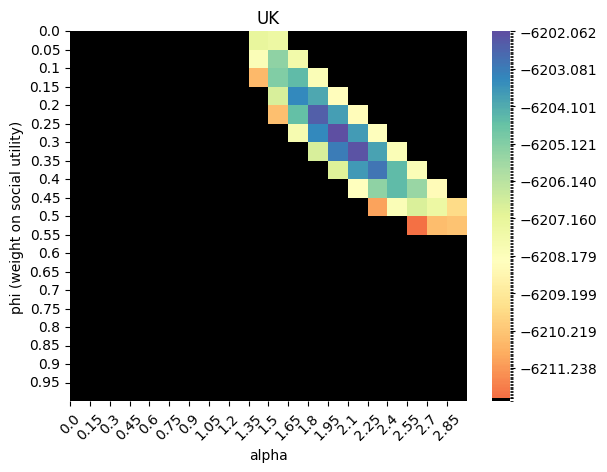

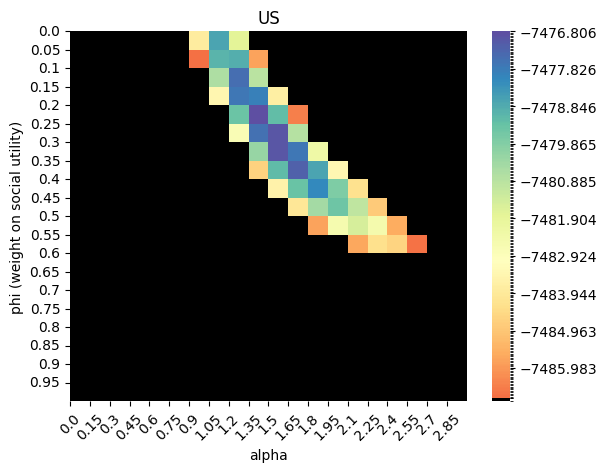

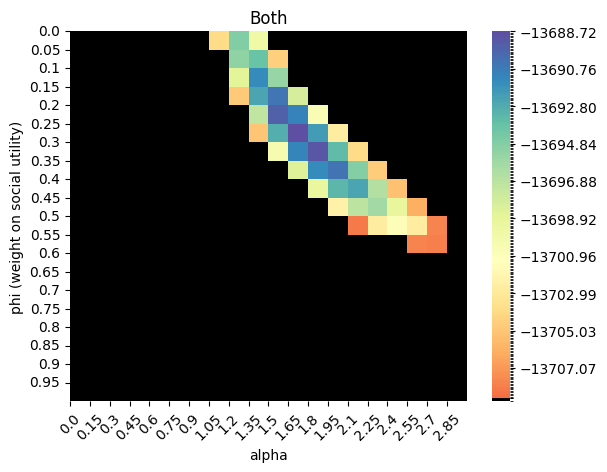

US best fit: (4, 9)
UK best fit: (5, 13)
best fit: (5, 11)
cost: 0.1


C:\Users\myuhk\AppData\Local\Temp\ipykernel_12972\3123264684.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w,cost)][int((s-S)*20)]) for s in measured_values)


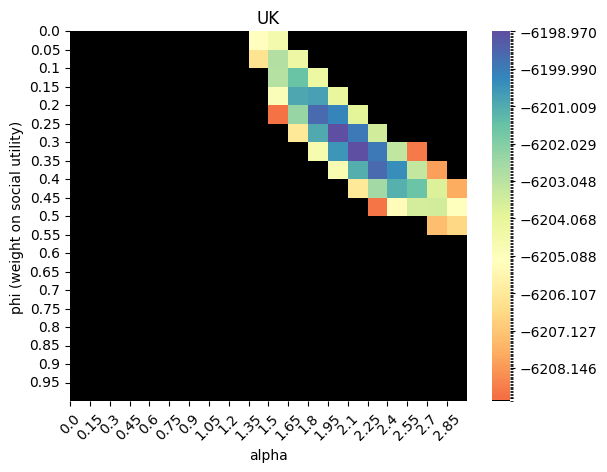

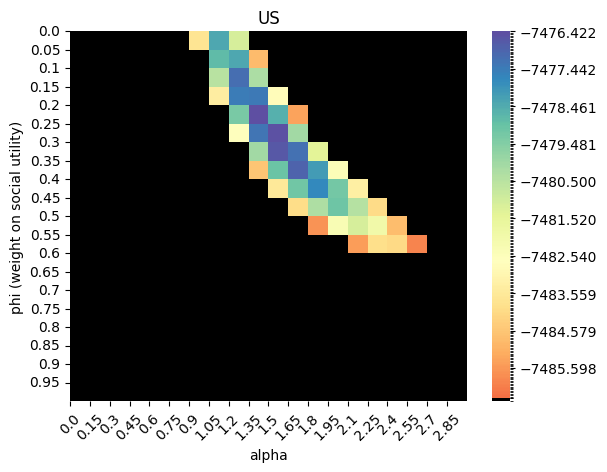

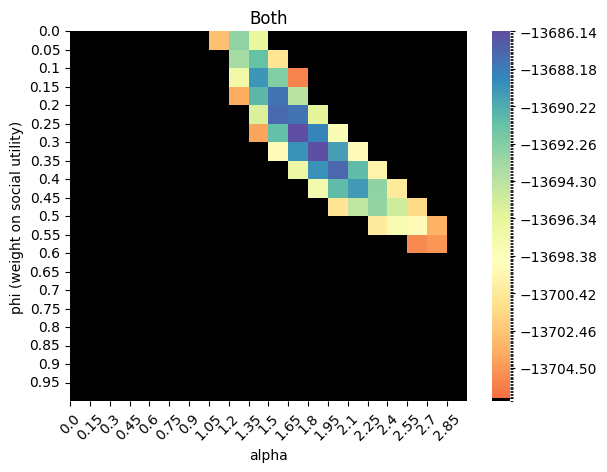

US best fit: (4, 9)
UK best fit: (6, 14)
best fit: (5, 11)
cost: 0.2


C:\Users\myuhk\AppData\Local\Temp\ipykernel_12972\3123264684.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w,cost)][int((s-S)*20)]) for s in measured_values)


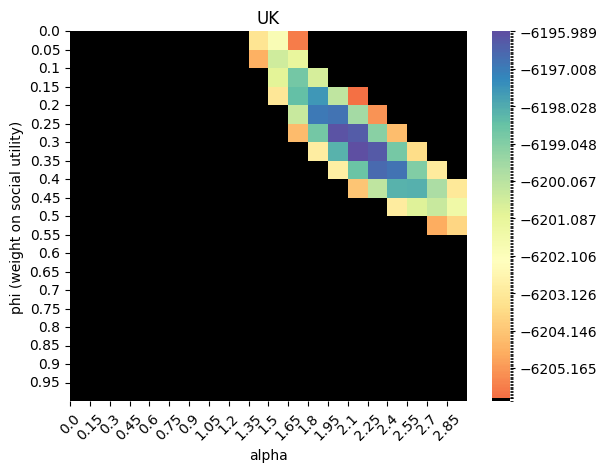

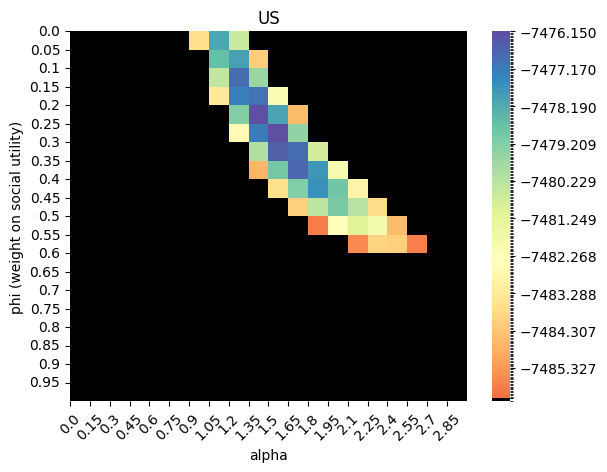

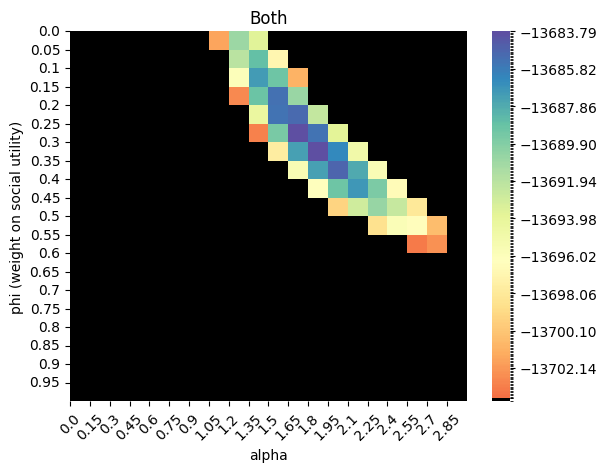

US best fit: (4, 9)
UK best fit: (6, 14)
best fit: (6, 12)
cost: 0.30000000000000004


C:\Users\myuhk\AppData\Local\Temp\ipykernel_12972\3123264684.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w,cost)][int((s-S)*20)]) for s in measured_values)


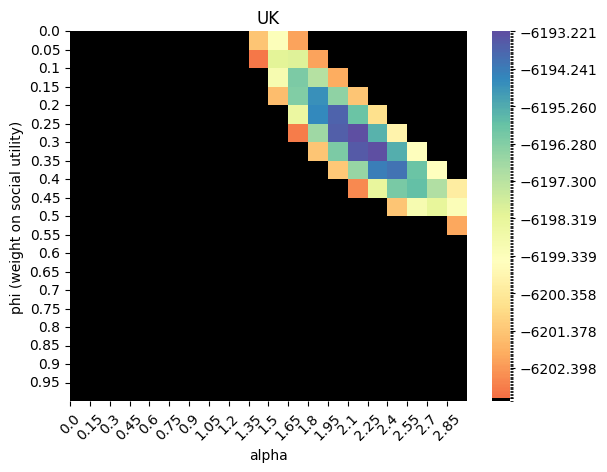

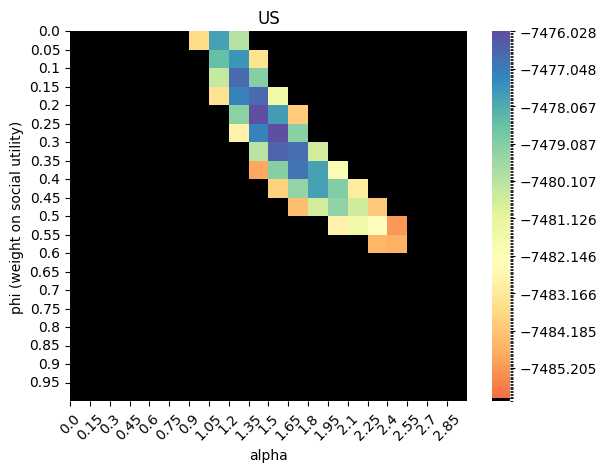

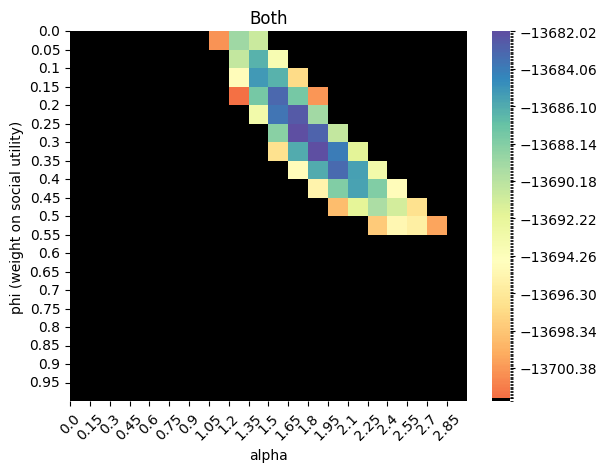

US best fit: (4, 9)
UK best fit: (5, 14)
best fit: (6, 12)
cost: 0.4


C:\Users\myuhk\AppData\Local\Temp\ipykernel_12972\3123264684.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w,cost)][int((s-S)*20)]) for s in measured_values)


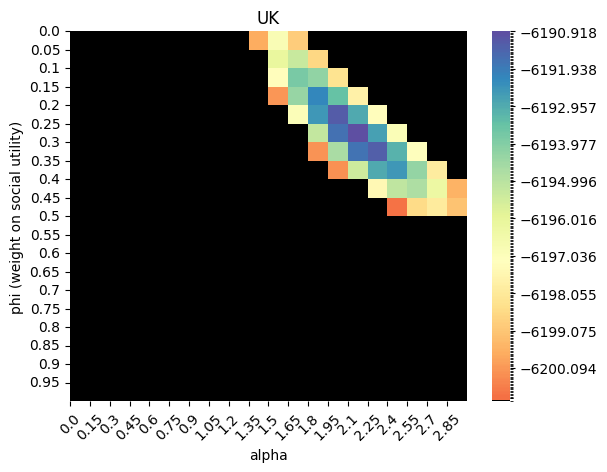

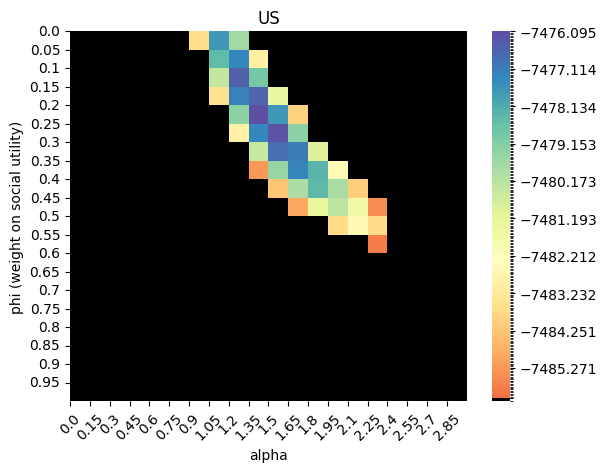

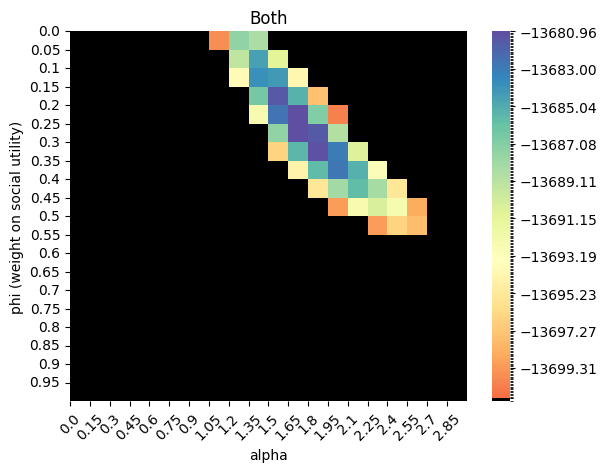

US best fit: (4, 9)
UK best fit: (5, 14)
best fit: (4, 11)
cost: 0.5


C:\Users\myuhk\AppData\Local\Temp\ipykernel_12972\3123264684.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w,cost)][int((s-S)*20)]) for s in measured_values)


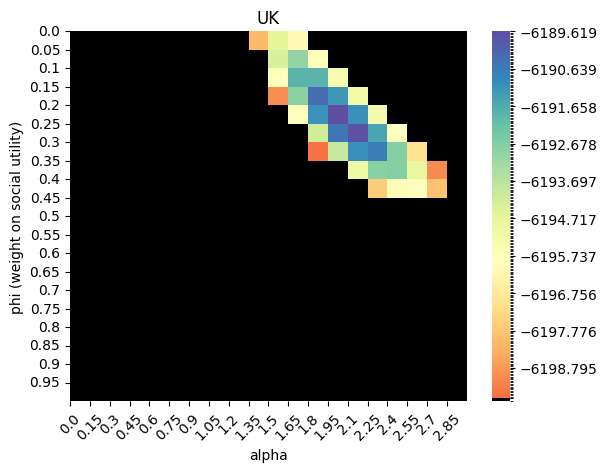

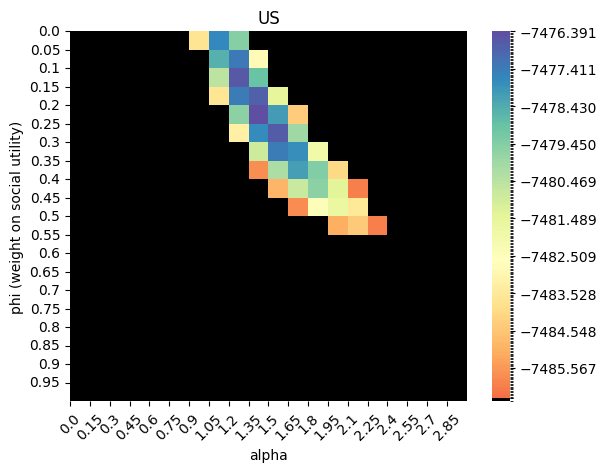

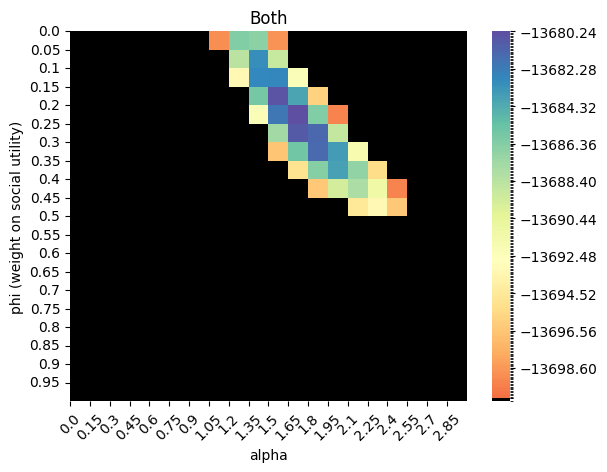

US best fit: (4, 9)
UK best fit: (4, 13)
best fit: (4, 11)
cost: 0.6000000000000001


C:\Users\myuhk\AppData\Local\Temp\ipykernel_12972\3123264684.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w,cost)][int((s-S)*20)]) for s in measured_values)


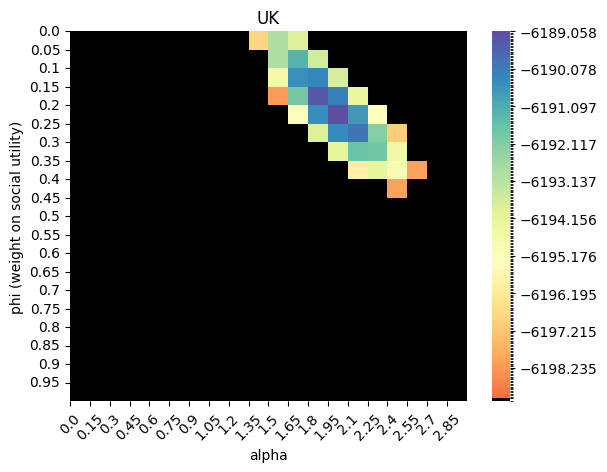

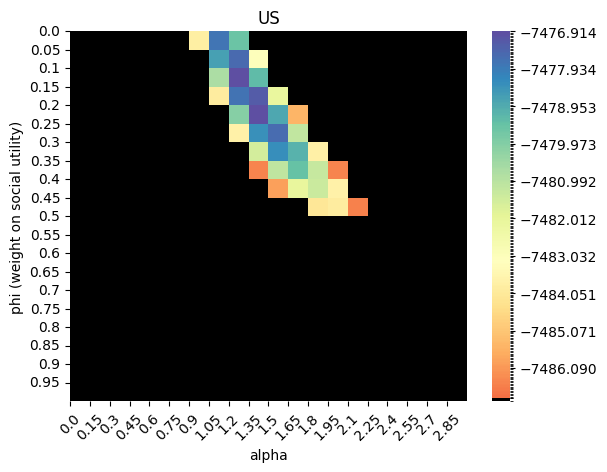

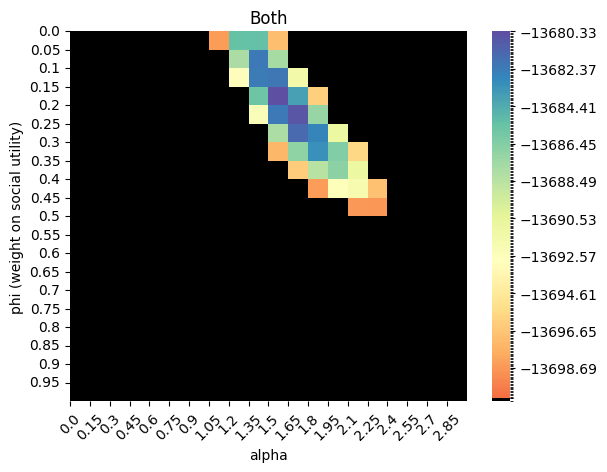

US best fit: (2, 8)
UK best fit: (4, 13)
best fit: (3, 10)
cost: 0.7000000000000001


C:\Users\myuhk\AppData\Local\Temp\ipykernel_12972\3123264684.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w,cost)][int((s-S)*20)]) for s in measured_values)


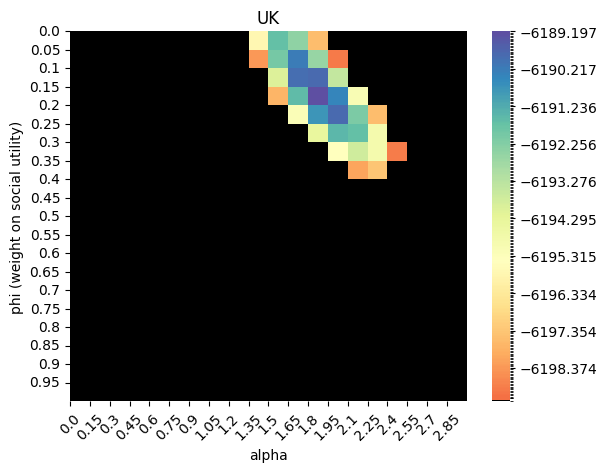

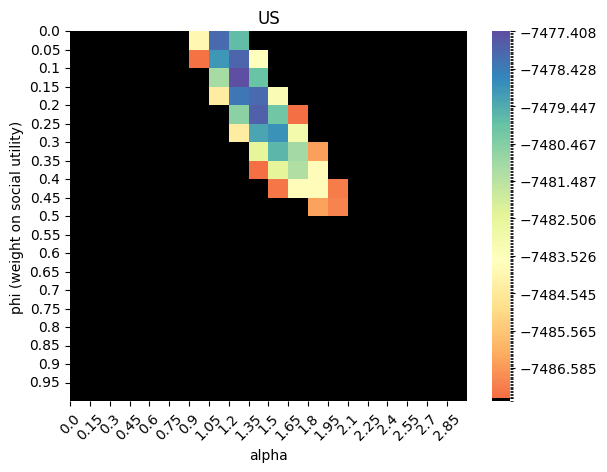

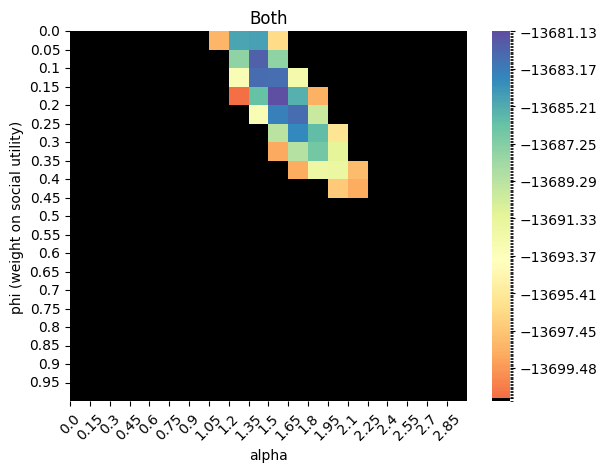

US best fit: (2, 8)
UK best fit: (3, 12)
best fit: (3, 10)
cost: 0.8


C:\Users\myuhk\AppData\Local\Temp\ipykernel_12972\3123264684.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w,cost)][int((s-S)*20)]) for s in measured_values)


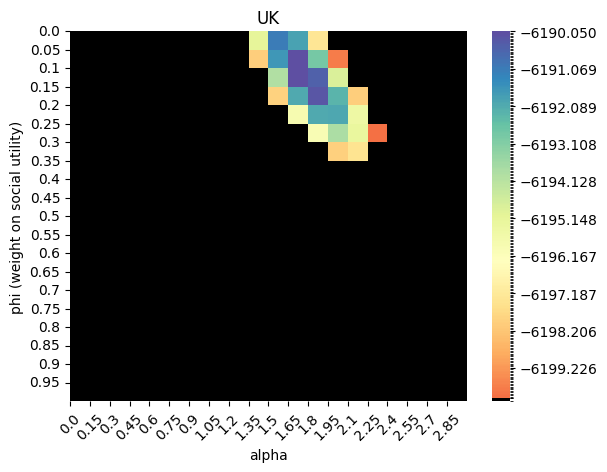

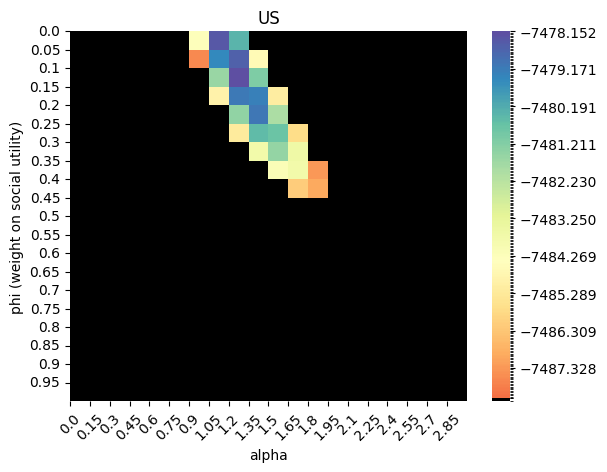

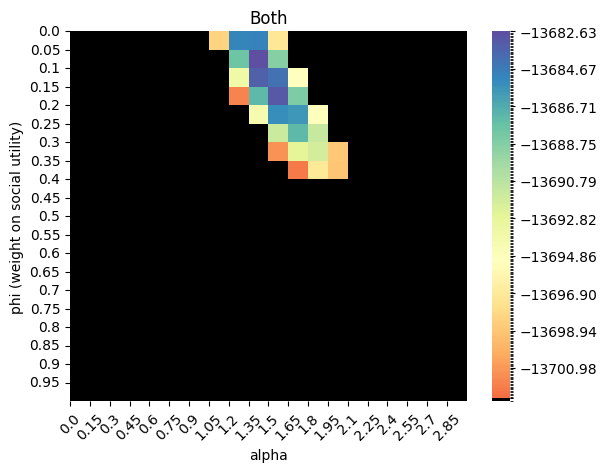

US best fit: (2, 8)
UK best fit: (1, 11)
best fit: (1, 9)
cost: 0.9


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
def test_fit(data,P_l1,cost):
    # test fit of model, P_l1 with data
    fit_judgement=dict()    
    for w in utterences:
        fit_judgement[w] = np.zeros((len(possible_phi),len(possible_alpha)))
        measured_values = data[((data['intensifier'] == w[0]) & (data['predicate'] == w[1]))]['predicate Z-score'].values
        # print minimum of measured values
        for i in range(len(possible_phi)):
            for j in range(len(possible_alpha)):
                fit_judgement[w][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],w,cost)][int((s-S)*20)]) for s in measured_values)
    return fit_judgement
# Define a custom colormap
base_cmap = sns.color_palette("Spectral", as_cmap=True)  # Base colormap
colors = ["black"] + list(base_cmap(np.linspace(0.2, 1, 256)))  # Add black for below threshold
custom_cmap = ListedColormap(colors)

def plot_fits(fit_judgement, possible_alpha, possible_phi,title,minus_thresh):
    # Define a normalization function
    threshold = np.max(np.sum([fit_judgement[w] for w in utterences],axis=0))+minus_thresh
    bounds = [-30000, threshold] + list(np.linspace(threshold, np.max(np.sum([fit_judgement[w] for w in utterences],axis=0)), 256))
    norm = BoundaryNorm(bounds, len(bounds) - 1)
    sns.heatmap(np.sum([fit_judgement[w] for w in utterences],axis=0), cmap=custom_cmap, norm=norm, cbar=True)# label x and y by the possible values
    plt.xticks(range(len(possible_alpha)), [round(x, 2) for x in possible_alpha])
    plt.yticks(range(len(possible_phi)), [round(x, 2) for x in possible_phi])
    # label x and y axis
    plt.xlabel('alpha')
    plt.ylabel('phi (weight on social utility)')
    # rotate y ticks by 90
    plt.xticks(rotation=45)
    # label colors in heatmap
    plt.title(title)
    # plt.colorbar()
    plt.show()
for cost in np.arange(0,1,0.1):
    fit_judgement = test_fit(dialogue,P_l1,cost)
    UK_fit_judgement = test_fit(dataframes[0],P_l1,cost)
    US_fit_judgement = test_fit(dataframes[3],P_l1,cost)
    plot_fits(UK_fit_judgement,possible_alpha,possible_phi,'UK',-10)
    plot_fits(US_fit_judgement,possible_alpha,possible_phi,'US',-10)
    # plot both
    plot_fits(fit_judgement,possible_alpha,possible_phi,'Both',-20)
    # print best fit for US and UK
    print(f"US best fit: {np.unravel_index(np.argmax(np.sum([US_fit_judgement[w] for w in utterences],axis=0), axis=None), np.sum([fit_judgement[w] for w in utterences],axis=0).shape)}")
    print(f"UK best fit: {np.unravel_index(np.argmax(np.sum([UK_fit_judgement[w] for w in utterences],axis=0), axis=None), np.sum([fit_judgement[w] for w in utterences],axis=0).shape)}")
    print(f"best fit: {np.unravel_index(np.argmax(np.sum([fit_judgement[w] for w in utterences],axis=0), axis=None), np.sum([fit_judgement[w] for w in utterences],axis=0).shape)}")
    print(f"cost: {cost}")

# plot_fits(new_UK_fit_judgement,possible_alpha,possible_phi,'UK',-10)
# plot_fits(new_US_fit_judgement,possible_alpha,possible_phi,'US',-10)
# # plot both
# plot_fits(new_fit_judgement,possible_alpha,possible_phi,'Both',-20)
# # print best fit for US and UK
# print(f"US best fit: {np.unravel_index(np.argmax(np.sum([new_US_fit_judgement[w] for w in utterences],axis=0), axis=None), np.sum([new_US_fit_judgement[w] for w in utterences],axis=0).shape)}")
# print(f"UK best fit: {np.unravel_index(np.argmax(np.sum([new_UK_fit_judgement[w] for w in utterences],axis=0), axis=None), np.sum([new_UK_fit_judgement[w] for w in utterences],axis=0).shape)}")
# print(f"best fit: {np.unravel_index(np.argmax(np.sum([new_fit_judgement[w] for w in utterences],axis=0), axis=None), np.sum([new_fit_judgement[w] for w in utterences],axis=0).shape)}")

[0.30000000000000004, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.15000000000000002, 0.15000000000000002, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.65, 1.65, 1.5, 1.5, 1.3499999999999999, 1.3499999999999999, 1.3499999999999999, 1.3499999999999999, 1.2]
[0.2, 0.25, 0.25, 0.25, 0.25, 0.15000000000000002, 0.15000000000000002, 0.15000000000000002, 0.05, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.5, 1.65, 1.65, 1.65, 1.65, 1.5, 1.5, 1.5, 1.3499999999999999, 1.3499999999999999, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2]


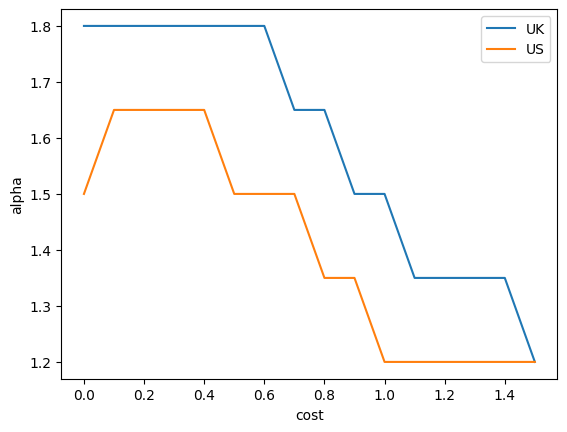

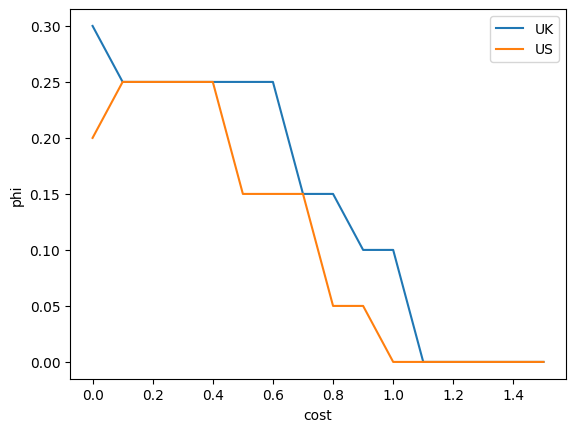

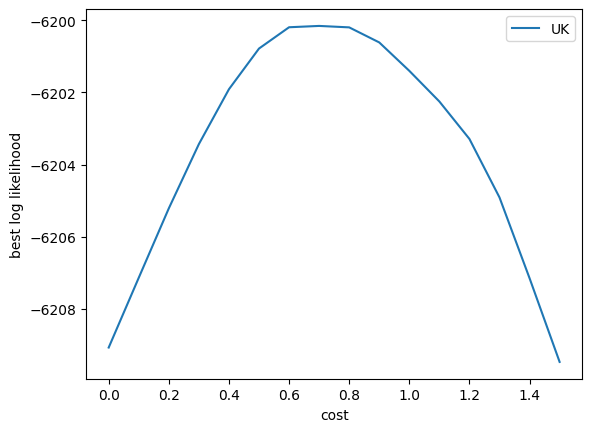

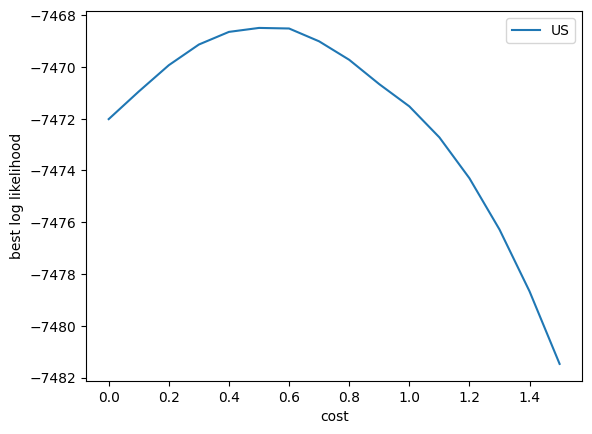

In [208]:
# print best values
US_log_likelihoods = []
UK_log_likelihoods = []
for i in range(len(costs)):
    UK_log_likelihoods.append(np.max(np.sum([UK_judgements[i][w] for w in utterences],axis=0)))
    US_log_likelihoods.append(np.max(np.sum([US_judgements[i][w] for w in utterences],axis=0)))
UK_alphas = []
US_alphas = []
UK_phis = []
US_phis = []
for i in range(len(costs)):
    US_phis.append(possible_phi[np.unravel_index(np.argmax(np.sum([US_judgements[i][w] for w in utterences],axis=0), axis=None), np.sum([US_fit_judgement[w] for w in utterences],axis=0).shape)[0]])
    US_alphas.append(possible_alpha[np.unravel_index(np.argmax(np.sum([US_judgements[i][w] for w in utterences],axis=0), axis=None), np.sum([US_fit_judgement[w] for w in utterences],axis=0).shape)[1]])
    UK_phis.append(possible_phi[np.unravel_index(np.argmax(np.sum([UK_judgements[i][w] for w in utterences],axis=0), axis=None), np.sum([UK_fit_judgement[w] for w in utterences],axis=0).shape)[0]])
    UK_alphas.append(possible_alpha[np.unravel_index(np.argmax(np.sum([UK_judgements[i][w] for w in utterences],axis=0), axis=None), np.sum([UK_fit_judgement[w] for w in utterences],axis=0).shape)[1]])
print(UK_phis)
print(UK_alphas)
print(US_phis)
print(US_alphas)
# graph for alphas
plt.plot(costs,UK_alphas,label='UK')
plt.plot(costs,US_alphas,label='US')
plt.legend()
plt.xlabel('cost')
plt.ylabel('alpha')
plt.show()
# graph for phis
plt.plot(costs,UK_phis,label='UK')
plt.plot(costs,US_phis,label='US')
plt.legend()
plt.xlabel('cost')
plt.ylabel('phi')
plt.show()
# graph for log likelihoods
plt.plot(costs,UK_log_likelihoods,label='UK')
# plt.plot(costs,US_log_likelihoods,label='US')
plt.legend()
plt.xlabel('cost')
plt.ylabel('best log likelihood')
plt.show()
# plot with orange line
plt.plot(costs,US_log_likelihoods,label='US')
plt.legend()
plt.xlabel('cost')
plt.ylabel('best log likelihood')
plt.show()

In [213]:
# print best values
both_judgements = []
for i in range(len(costs)):
    both_judgements.append(np.sum([UK_judgements[i][w]  for w in utterences]+[US_judgements[i][w] for w in utterences],axis=0))
for i in range(len(costs)):
    print(f"best value for cost {costs[i]}")
    print(f"US best fit: {np.unravel_index(np.argmax(np.sum([US_judgements[i][w] for w in utterences],axis=0), axis=None), np.sum([US_fit_judgement[w] for w in utterences],axis=0).shape)}")
    print(f"UK best fit: {np.unravel_index(np.argmax(np.sum([UK_judgements[i][w] for w in utterences],axis=0), axis=None), np.sum([UK_fit_judgement[w] for w in utterences],axis=0).shape)}")
    print(f"Both best fit: {np.unravel_index(np.argmax(both_judgements[i], axis=None), both_judgements[i].shape)}")
    print(f"best value for US: {np.max(np.sum([US_judgements[i][w] for w in utterences],axis=0))}")
    print(f"best value for UK: {np.max(np.sum([UK_judgements[i][w] for w in utterences],axis=0))}")
    print(f"best value for both: {np.max(both_judgements[i])}")
    

best value for cost 0.0
US best fit: (4, 10)
UK best fit: (6, 12)
Both best fit: (5, 11)
best value for US: -7472.015835422143
best value for UK: -6209.081793292035
best value for both: -13681.403619114799
best value for cost 0.1
US best fit: (5, 11)
UK best fit: (5, 12)
Both best fit: (5, 11)
best value for US: -7470.949628914592
best value for UK: -6207.14329864698
best value for both: -13678.752737131137
best value for cost 0.2
US best fit: (5, 11)
UK best fit: (5, 12)
Both best fit: (6, 12)
best value for US: -7469.931862776331
best value for UK: -6205.216519247332
best value for both: -13676.07691177237
best value for cost 0.30000000000000004
US best fit: (5, 11)
UK best fit: (5, 12)
Both best fit: (6, 12)
best value for US: -7469.1336432863845
best value for UK: -6203.433023291563
best value for both: -13673.7814092286
best value for cost 0.4
US best fit: (5, 11)
UK best fit: (5, 12)
Both best fit: (4, 11)
best value for US: -7468.64521839181
best value for UK: -6201.909470812462

# Using theta for obtaining U_inf function

Define $U_{inf}$ by first defining $P_{L_0}$(s|w) using threshold function

grid search (as opposed to optimizing)

In [384]:
from itertools import product
utterences =list(U_soc.keys())
predicates = list(set(w[1] for w in utterences))
intensifiers = list(set(w[0] for w in utterences))
states = np.arange(-5.7, 4.5, 0.1)
possible_phi = np.arange(0,1,0.1)
possible_alpha = np.arange(0.6,2.4,0.3)
Alpha = min(possible_alpha)
Phi = min(possible_phi)
S = min(states)
theta_to_test = list(np.arange(-3,-1,0.4))+list(np.arange(-1,1,0.1))+list(np.arange(1,2,0.2))
def P_state(s):
    # return gaussian with mean 0 std 1
    return (1/np.sqrt(2*np.pi))*np.exp(-((s-0)**2)/2)
P_state = dict((s,P_state(s)) for s in states)
measured_values = dict()
for w in intensifiers:   
    for pred in predicates:
        measured_values[(w,pred)] = dialogue[((dialogue['intensifier'] == w) & (dialogue['predicate'] == pred))]['Z-Score Difference'].values       
epsilon = 0.01
theta_U_inf = dict()
P_l1 = dict()
infty = 10000000
count = 0
# define theta_U_inf
for t in theta_to_test:
    arr = np.array([epsilon*P_state[s] if s <= t else P_state[s] for s in states])
    theta_U_inf[t] = np.log(arr)-np.log(np.sum(arr))
# create array with dimensions (len(possible_alpha),len(possible_phi)) - keep track of best log value and theta values
best_phi_alpha = [[(-infty,[0,0,0,0,0]) for i in range(len(possible_alpha))] for j in range(len(possible_phi))]
for thetas in product(theta_to_test,repeat=len(intensifiers)): # this is where I can paralelize
    for phi in possible_phi:
        for alpha in possible_alpha:
            for pred in predicates:
                P_grid = np.zeros((len(states),len(intensifiers)))
                for i in range(len(states)):
                    s=states[i]
                    values = P_state[s]*softmax([alpha*(phi*U_soc[(intensifiers[i],pred)] + (1-phi)*theta_U_inf[thetas[i]][int((s-S)*10)]) for i in range(len(intensifiers))])
                    for j in range(len(intensifiers)):
                        P_grid[i][j] = values[j]
                # swap rows and columns of P_grid
                # so each row is the same intensifier
                P_grid = np.array(P_grid).T
                # P_grid is P_s1(w|s,phi,alpha)*P(s) unnormalized
                for i in range(len(intensifiers)):
                    w = intensifiers[i]
                    P_l1[(w,pred)] = P_grid[i] # row with lots of states
                    # normalize over states adds up to 1
                    P_l1[(w,pred)] = P_l1[(w,pred)]/np.sum(P_l1[(w,pred)])
            log_likelihood = 0
            for w in intensifiers:   
                for pred in predicates:
                    log_likelihood +=np.sum(np.log(P_l1[(w,pred)][int((s-S)*10)]) for s in measured_values[(w,pred)])
            if log_likelihood > best_phi_alpha[int((phi-Phi)*10)][int((alpha-Alpha)*10/3)][0]:
                best_phi_alpha[int((phi-Phi)*10)][int((alpha-Alpha)*10/3)] = (log_likelihood,[alpha,phi,thetas])
    count+=1
    print(count)
    if count==40:
        print(best_phi_alpha)
        break
arr = np.array([[best_phi_alpha[i][j][0] for i in range(len(best_phi_alpha))] for j in range(len(best_phi_alpha[0]))])
print("index of optimal value",np.unravel_index(np.argmax(arr), arr.shape))
print("maximum value",np.max(arr))

C:\Users\myuhk\AppData\Local\Temp\ipykernel_33316\2172518750.py:53: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  log_likelihood +=np.sum(np.log(P_l1[(w,pred)][int((s-S)*10)]) for s in measured_values[(w,pred)])


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
[[(-6491.9427830486475, [0.6, 0.0, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.709603945589, [1.1999999999999997, 0.0, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.709603945589, [1.4999999999999998, 0.0, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.709603945589, [1.7999999999999998, 0.0, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.709603945589, [2.0999999999999996, 0.0, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-10000000, [0, 0, 0, 0, 0])], [(-6491.513211597038, [0.6, 0.1, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.70960394559, [1.1999999999999997, 0.1, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [1.4999999999999998, 0.1, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [1.7999999999999998, 0.1, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [2.0999999999999996, 0.1, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-10000000, [0, 0, 0, 0, 0])], [(-6491.14244248249, [0.6, 0.2, (-3.0, -3.0, -3

In [385]:
from itertools import product
utterences =list(U_soc.keys())
predicates = list(set(w[1] for w in utterences))
intensifiers = list(set(w[0] for w in utterences))
states = np.arange(-5.7, 4.5, 0.1)
possible_phi = np.arange(0,1,0.1)
possible_alpha = np.arange(0.6,2.4,0.3)
Alpha = min(possible_alpha)
Phi = min(possible_phi)
S = min(states)
theta_to_test = list(np.arange(-3,-1,0.4))+list(np.arange(-1,1,0.1))+list(np.arange(1,2,0.2))
def softmax_rowwise(arr):
    # Subtract the maximum value from each row for numerical stability
    exp_vals = np.exp(arr - np.max(arr, axis=1, keepdims=True))
    # Normalize each row
    softmax_vals = exp_vals / np.sum(exp_vals, axis=1, keepdims=True)
    return softmax_vals

def P_state(s):
    # return gaussian with mean 0 std 1
    return (1/np.sqrt(2*np.pi))*np.exp(-((s-0)**2)/2)
P_state = np.array([P_state(s) for s in states])
measured_values = dict()
for w in intensifiers:   
    for pred in predicates:
        measured_values[(w,pred)] = dialogue[((dialogue['intensifier'] == w) & (dialogue['predicate'] == pred))]['Z-Score Difference'].values       
epsilon = 0.01
theta_U_inf = dict()
P_l1 = dict()
infty = 10000000
count = 0
# define theta_U_inf
for t in theta_to_test:
    arr = np.array([epsilon*P_state[i] if states[i] <= t else P_state[i] for i in range(len(states))])
    theta_U_inf[t] = np.log(arr)-np.log(np.sum(arr))
# create array with dimensions (len(possible_alpha),len(possible_phi)) - keep track of best log value and theta values
best_phi_alpha = [[(-infty,[0,0,0,0,0]) for i in range(len(possible_alpha))] for j in range(len(possible_phi))]
for thetas in product(theta_to_test,repeat=len(intensifiers)): # this is where I can paralelize
    log_l_arr = np.zeros((len(possible_phi),len(possible_alpha)))
    for phi in possible_phi:
        for alpha in possible_alpha:
            for pred in predicates:
                P_grid = np.zeros((len(states),len(intensifiers)))  
                for i in range(len(states)):
                    s=states[i]
                    for j in range(len(intensifiers)):
                        P_grid[i][j] = (1-phi)*theta_U_inf[thetas[j]][int((s-S)*10)]
                P_grid = P_grid + phi*np.array([U_soc[(intensifiers[j],pred)] for j in range(len(intensifiers))])
                P_grid = alpha*P_grid
                P_grid = softmax_rowwise(P_grid)
                # multiply row i of P_grid by P_state[states[i]] u
                # swap rows and columns of P_grid
                # so each row is the same intensifier
                P_grid = np.array(P_grid).T
                P_grid=P_grid*P_state
                # P_grid is P_s1(w|s,phi,alpha)*P(s) unnormalized
                for i in range(len(intensifiers)):
                    w = intensifiers[i]
                    P_l1[(w,pred)] = P_grid[i] # row with lots of states
                    # normalize over states adds up to 1
                    P_l1[(w,pred)] = P_l1[(w,pred)]/np.sum(P_l1[(w,pred)])
            log_likelihood = 0
            for w in intensifiers:   
                for pred in predicates:
                    log_likelihood +=np.sum(np.log(P_l1[(w,pred)][int((s-S)*10)]) for s in measured_values[(w,pred)])
            if log_likelihood > best_phi_alpha[int((phi-Phi)*10)][int((alpha-Alpha)*10/3)][0]:
                best_phi_alpha[int((phi-Phi)*10)][int((alpha-Alpha)*10/3)] = (log_likelihood,[alpha,phi,thetas])

    count+=1
    print(count)
    if count==40:
        print(best_phi_alpha)
        break
arr = np.array([[best_phi_alpha[i][j][0] for i in range(len(best_phi_alpha))] for j in range(len(best_phi_alpha[0]))])
print("index of optimal value",np.unravel_index(np.argmax(arr), arr.shape))
print("maximum value",np.max(arr))
def func_to_iterate_over(*params):
    thetas = params[:5]
    log_l_arr = np.zeros((len(possible_phi),len(possible_alpha)))
    for phi in possible_phi:
        for alpha in possible_alpha:
            for pred in predicates:
                P_grid = np.zeros((len(states),len(intensifiers)))  
                for i in range(len(states)):
                    s=states[i]
                    for j in range(len(intensifiers)):
                        P_grid[i][j] = (1-phi)*theta_U_inf[thetas[j]][int((s-S)*10)]
                P_grid = P_grid + phi*np.array([U_soc[(intensifiers[j],pred)] for j in range(len(intensifiers))])
                P_grid = alpha*P_grid
                P_grid = softmax_rowwise(P_grid)
                # multiply row i of P_grid by P_state[states[i]] u
                # swap rows and columns of P_grid
                # so each row is the same intensifier
                P_grid = np.array(P_grid).T
                P_grid=P_grid*P_state
                # P_grid is P_s1(w|s,phi,alpha)*P(s) unnormalized
                for i in range(len(intensifiers)):
                    w = intensifiers[i]
                    P_l1[(w,pred)] = P_grid[i] # row with lots of states
                    # normalize over states adds up to 1
                    P_l1[(w,pred)] = P_l1[(w,pred)]/np.sum(P_l1[(w,pred)])
            log_likelihood = 0
            for w in intensifiers:   
                for pred in predicates:
                    log_likelihood +=np.sum(np.log(P_l1[(w,pred)][int((s-S)*10)]) for s in measured_values[(w,pred)])
            log_l_arr[int((phi-Phi)*10)][int((alpha-Alpha)*10/3)] = log_likelihood
    return (log_l_arr,thetas)


C:\Users\myuhk\AppData\Local\Temp\ipykernel_33316\1831557446.py:65: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  log_likelihood +=np.sum(np.log(P_l1[(w,pred)][int((s-S)*10)]) for s in measured_values[(w,pred)])


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
[[(-6491.9427830486475, [0.6, 0.0, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.709603945589, [1.1999999999999997, 0.0, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.709603945589, [1.4999999999999998, 0.0, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.709603945589, [1.7999999999999998, 0.0, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.709603945589, [2.0999999999999996, 0.0, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-10000000, [0, 0, 0, 0, 0])], [(-6491.513211597038, [0.6, 0.1, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.70960394559, [1.1999999999999997, 0.1, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [1.4999999999999998, 0.1, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [1.7999999999999998, 0.1, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [2.0999999999999996, 0.1, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-10000000, [0, 0, 0, 0, 0])], [(-6491.14244248249, [0.6, 0.2, (-3.0, -3.0, -3

In [387]:
print(q==r)

q = [[(-6491.9427830486475, [0.6, 0.0, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.709603945589, [1.1999999999999997, 0.0, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.709603945589, [1.4999999999999998, 0.0, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.709603945589, [1.7999999999999998, 0.0, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.709603945589, [2.0999999999999996, 0.0, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-10000000, [0, 0, 0, 0, 0])], [(-6491.513211597038, [0.6, 0.1, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.70960394559, [1.1999999999999997, 0.1, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [1.4999999999999998, 0.1, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [1.7999999999999998, 0.1, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [2.0999999999999996, 0.1, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-10000000, [0, 0, 0, 0, 0])], [(-6491.14244248249, [0.6, 0.2, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.70960394559, [1.1999999999999997, 0.2, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.709603945589, [1.4999999999999998, 0.2, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [1.7999999999999998, 0.2, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [2.0999999999999996, 0.2, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-10000000, [0, 0, 0, 0, 0])], [(-6490.8451107866, [0.6, 0.30000000000000004, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.70960394559, [1.1999999999999997, 0.30000000000000004, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [1.4999999999999998, 0.30000000000000004, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.709603945589, [1.7999999999999998, 0.30000000000000004, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.709603945589, [2.0999999999999996, 0.30000000000000004, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-10000000, [0, 0, 0, 0, 0])], [(-6490.638360413488, [0.6, 0.4, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.70960394559, [1.1999999999999997, 0.4, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [1.4999999999999998, 0.4, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.709603945589, [1.7999999999999998, 0.4, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [2.0999999999999996, 0.4, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-10000000, [0, 0, 0, 0, 0])], [(-6490.542441350569, [0.6, 0.5, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.179308557311, [1.1999999999999997, 0.5, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.70960394559, [1.4999999999999998, 0.5, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [1.7999999999999998, 0.5, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [2.0999999999999996, 0.5, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-10000000, [0, 0, 0, 0, 0])], [(-6490.581297747365, [0.6, 0.6000000000000001, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6491.560160544596, [1.1999999999999997, 0.6000000000000001, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.606933364191, [1.4999999999999998, 0.6000000000000001, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.709603945589, [1.7999999999999998, 0.6000000000000001, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [2.0999999999999996, 0.6000000000000001, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-10000000, [0, 0, 0, 0, 0])], [(-6490.753377909152, [0.8999999999999999, 0.7000000000000001, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6491.161023828305, [1.1999999999999997, 0.7000000000000001, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6491.861520131845, [1.4999999999999998, 0.7000000000000001, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.70960394559, [1.7999999999999998, 0.7000000000000001, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [2.0999999999999996, 0.7000000000000001, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-10000000, [0, 0, 0, 0, 0])], [(-6490.97911431332, [0.8999999999999999, 0.8, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6491.093301132742, [1.1999999999999997, 0.8, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6491.439740833454, [1.4999999999999998, 0.8, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6491.941994937454, [1.7999999999999998, 0.8, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.539737635666, [2.0999999999999996, 0.8, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-10000000, [0, 0, 0, 0, 0])], [(-6491.591746839209, [0.8999999999999999, 0.9, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6491.5284810059575, [1.1999999999999997, 0.9, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6491.588009742184, [1.4999999999999998, 0.9, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6491.737046011515, [1.7999999999999998, 0.9, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6491.946519003282, [2.0999999999999996, 0.9, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-10000000, [0, 0, 0, 0, 0])]]
r = [[(-6491.9427830486475, [0.6, 0.0, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.709603945589, [1.1999999999999997, 0.0, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.709603945589, [1.4999999999999998, 0.0, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.709603945589, [1.7999999999999998, 0.0, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.709603945589, [2.0999999999999996, 0.0, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-10000000, [0, 0, 0, 0, 0])], [(-6491.513211597038, [0.6, 0.1, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.70960394559, [1.1999999999999997, 0.1, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [1.4999999999999998, 0.1, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [1.7999999999999998, 0.1, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [2.0999999999999996, 0.1, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-10000000, [0, 0, 0, 0, 0])], [(-6491.14244248249, [0.6, 0.2, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.70960394559, [1.1999999999999997, 0.2, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.709603945589, [1.4999999999999998, 0.2, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [1.7999999999999998, 0.2, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [2.0999999999999996, 0.2, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-10000000, [0, 0, 0, 0, 0])], [(-6490.8451107866, [0.6, 0.30000000000000004, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.70960394559, [1.1999999999999997, 0.30000000000000004, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [1.4999999999999998, 0.30000000000000004, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.709603945589, [1.7999999999999998, 0.30000000000000004, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.709603945589, [2.0999999999999996, 0.30000000000000004, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-10000000, [0, 0, 0, 0, 0])], [(-6490.638360413488, [0.6, 0.4, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.70960394559, [1.1999999999999997, 0.4, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [1.4999999999999998, 0.4, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.709603945589, [1.7999999999999998, 0.4, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [2.0999999999999996, 0.4, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-10000000, [0, 0, 0, 0, 0])], [(-6490.542441350569, [0.6, 0.5, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.179308557311, [1.1999999999999997, 0.5, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.70960394559, [1.4999999999999998, 0.5, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [1.7999999999999998, 0.5, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [2.0999999999999996, 0.5, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-10000000, [0, 0, 0, 0, 0])], [(-6490.581297747365, [0.6, 0.6000000000000001, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6491.560160544596, [1.1999999999999997, 0.6000000000000001, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.606933364191, [1.4999999999999998, 0.6000000000000001, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.709603945589, [1.7999999999999998, 0.6000000000000001, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [2.0999999999999996, 0.6000000000000001, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-10000000, [0, 0, 0, 0, 0])], [(-6490.753377909152, [0.8999999999999999, 0.7000000000000001, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6491.161023828305, [1.1999999999999997, 0.7000000000000001, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6491.861520131845, [1.4999999999999998, 0.7000000000000001, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.70960394559, [1.7999999999999998, 0.7000000000000001, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-6492.70960394559, [2.0999999999999996, 0.7000000000000001, (-3.0, -3.0, -3.0, -3.0, -3.0)]), (-10000000, [0, 0, 0, 0, 0])], [(-6490.97911431332, [0.8999999999999999, 0.8, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6491.093301132742, [1.1999999999999997, 0.8, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6491.439740833454, [1.4999999999999998, 0.8, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6491.941994937454, [1.7999999999999998, 0.8, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6492.539737635666, [2.0999999999999996, 0.8, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-10000000, [0, 0, 0, 0, 0])], [(-6491.591746839209, [0.8999999999999999, 0.9, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6491.5284810059575, [1.1999999999999997, 0.9, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6491.588009742184, [1.4999999999999998, 0.9, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6491.737046011515, [1.7999999999999998, 0.9, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-6491.946519003282, [2.0999999999999996, 0.9, (-3.0, -3.0, -3.0, -2.6, -3.0)]), (-10000000, [0, 0, 0, 0, 0])]]

True


In [ ]:
arr = np.array([[best_phi_alpha[i][j][0] for i in range(len(best_phi_alpha))] for j in range(len(best_phi_alpha[0]))])
print("index of optimal value",np.unravel_index(np.argmax(arr), arr.shape))
print("maximum value",np.max(arr))

(4, 1)


-1218.011258699506

In [341]:
arr[0][0]

-1218.1776540329195

Successfully doing parameter search

In [371]:
from scipy.optimize import minimize
states = np.arange(-5.7, 4.5, 0.1)
S = min(states)
def theta_U_s1(w,s,phi,U_inf):
    # corresponds to U_s1(w) in the paper
    return phi*U_soc[w] + (1-phi)*U_inf[w[0]][int((s-S)*10)]
def theta_P_s1(alpha,phi,s,pred,U_inf):
    # corresponds to P_S1(w|s,phi)
    return softmax([ alpha*theta_U_s1((w,pred),s,phi,U_inf) for w in intensifiers])
def P_state(s):
    # return gaussian with mean 0 std 1
    return (1/np.sqrt(2*np.pi))*np.exp(-((s-0)**2)/(2*1**2))
# Define the function to minimize
def func_to_minimize(params):
    thetas = params[:5]
    alpha = params[5]
    phi = params[6]
    epsilon = 0.1
    theta_U_inf = dict()
    P_l1 = dict()
    for i in range(len(intensifiers)):
        theta_U_inf[intensifiers[i]] = np.array([epsilon*P_state(s) if s <= thetas[i] else P_state(s) for s in states])
        theta_U_inf[intensifiers[i]] = theta_U_inf[intensifiers[i]]/sum(theta_U_inf[intensifiers[i]])
        theta_U_inf[intensifiers[i]] = np.log(theta_U_inf[intensifiers[i]])
    for pred in predicates:
        P_grid = []
        for s in states:
            P_grid.append(theta_P_s1(alpha,phi,s,pred,theta_U_inf)*P_state(s))
        # swap rows and columns of P_grid
        P_grid = np.array(P_grid).T
        for i in range(len(intensifiers)):
            w = intensifiers[i]
            P_l1[(w,pred)] = P_grid[i]
            # normalize so adds up to 1
            P_l1[(w,pred)] = P_l1[(w,pred)]/np.sum(P_l1[(w,pred)])
    # print(P_l1[('slightly', 'helpful')])
    log_likelihood = 0
    for w in intensifiers:   
        for pred in predicates:
            measured_values = dialogue[((dialogue['intensifier'] == w) & (dialogue['predicate'] == pred))]['Z-Score Difference'].values
            log_likelihood +=np.sum(np.log(P_l1[(w,pred)][int((s-S)*10)]) for s in measured_values)
        #     print(log_likelihood,w,phi,alpha, thetas)
        # print(w)
    print(log_likelihood)
    return -log_likelihood

# Initial guess
initial_guess = [-3,-3,-3,-3,-3, 0.6,0]

# Define bounds for each parameter
bounds = [(-3, 2)] * 5 + [(0.5,2.4),(0,1)] # 5 parameters, each ranging from -6 to 6
print(bounds)
# Run the optimization
result = minimize(func_to_minimize, initial_guess, method='CG', bounds=bounds)

print("Optimal Parameters:", result.x)
print("Minimum Value:", result.fun)

[(-3, 2), (-3, 2), (-3, 2), (-3, 2), (-3, 2), (0.5, 2.4), (0, 1)]
-6492.709603945589
-6492.709603945589
-6492.709603945589
-6492.709603945589
-6492.709603945589


C:\Users\myuhk\AppData\Local\Temp\ipykernel_33316\2169232797.py:54: RuntimeWarning: Method CG cannot handle bounds.
  result = minimize(func_to_minimize, initial_guess, method='CG', bounds=bounds)
C:\Users\myuhk\AppData\Local\Temp\ipykernel_33316\2169232797.py:41: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  log_likelihood +=np.sum(np.log(P_l1[(w,pred)][int((s-S)*10)]) for s in measured_values)


-6492.709603945589
-6492.709603945589
-6492.709603945589
Optimal Parameters: [-3.  -3.  -3.  -3.  -3.   0.6  0. ]
Minimum Value: 6492.709603945589


#### Record of results

Powell: 
Optimal Parameters: [-0.86296567 -3.83946815  0.11881361 -1.42704973 -2.35007019  0.54513784
  0.55593692]
Minimum Value: 7622.654024849191

SLSQP
Optimal Parameters: [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 5.24671918e-07 9.99998698e-01]
Minimum Value: 7773.548644439374

TNC:
Optimal Parameters: [0.         0.         1.         0.         0.         0.91291945, 1. ]
Minimum Value: 7773.548644439286

Nelder Mead:
Optimal Parameters: [ 0.0024747   0.0012909  -0.02271048  0.00263152  0.0018991   0.
  0.24250486]
Minimum Value: 7773.548644439286

trust-constr:
Optimal Parameters: [ 4.34396946e-08 -8.31980725e-09  1.00920297e+00  4.51582456e-08
  2.95320479e-08  1.54234285e+00  9.99406654e-01]
Minimum Value: 7773.710851762306

CG (starting from Powell):
Optimal Parameters: [-0.86296567 -3.83946815  0.11881361 -1.42704973 -2.35007019  0.91090539
  0.73335056]
Minimum Value: 7618.458113423883

BFGS
Optimal Parameters: [-0.86296567 -3.83946815  0.11881361 -1.42704973 -2.35007019  0.91090698
  0.73335143]
Minimum Value: 7618.458113423529

if epsilon = 0.01
Optimal Parameters: [-0.86296567 -3.83946815  0.11881361 -1.42704973 -2.35007019  1.01912567
  0.63853247]
Minimum Value: 7617.177330681999

Optimal Parameters: [-0.86296567 -3.83946815  0.11881361 -1.42704973 -2.35007019  1.1721982
  0.66993666]
Minimum Value: 3540.0624957110535

UK - powell
Optimal Parameters: [-0.74820619  3.29998798 -0.35618854 -1.42530311 -1.30979051  0.71469205
  0.15471767]
Minimum Value: 3486.965957556221
US - Powell
Optimal Parameters: [-1.33231743  3.69999889 -0.90685264 -1.37751888 -1.96941291  0.66226507
  0.05043027]
Minimum Value: 4047.0662567772947

US - CG
Optimal Parameters: [-1.         -1.          0.         -1.         -2.          0.14551575
 -0.01626904]
Minimum Value: 4141.407529004872

all - CG (eps=0.01)
Optimal Parameters: [-1.         -1.          0.         -1.         -2.          5.76009058
  0.98151698]
Minimum Value: 7760.495904387104

all - powell (eps = 0.05)
Optimal Parameters: [-0.92819993  3.15148861 -0.46783021 -1.42192592 -1.64916572  0.86230122
  0.02336677]
Minimum Value: 7555.227659795885

all - powell (eps = 0.1)
Optimal Parameters: [-0.93643047  3.06772275 -0.46583885 -1.44719902 -1.46653402  1.13121295
  0.04682317]
Minimum Value: 7560.259834445015

In [ ]:
intensifiers

['very', 'slightly', 'extremely', 'quite', 'kind of']

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


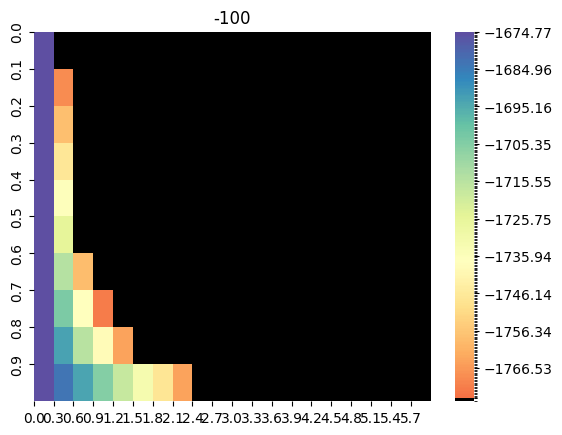

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


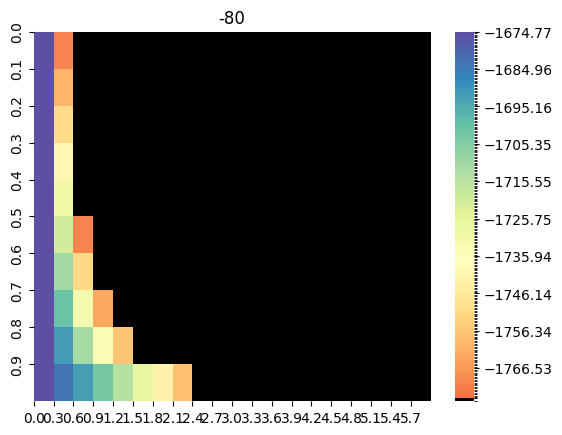

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


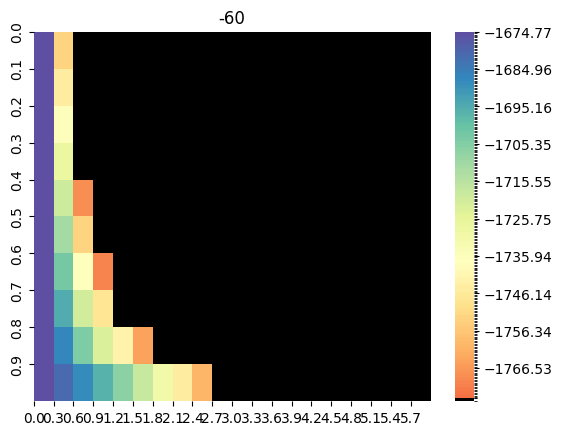

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


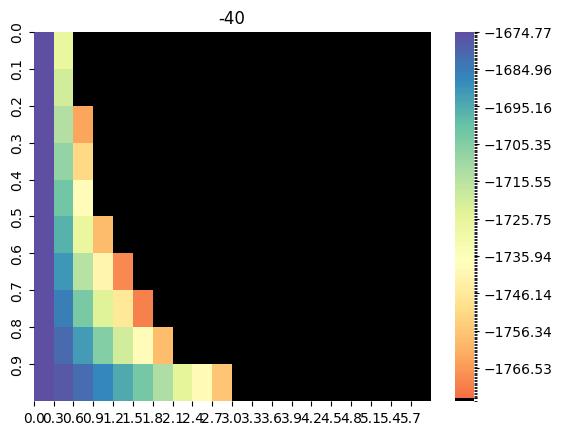

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


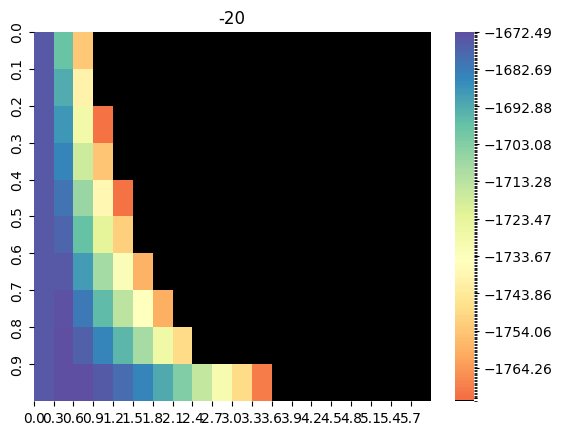

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


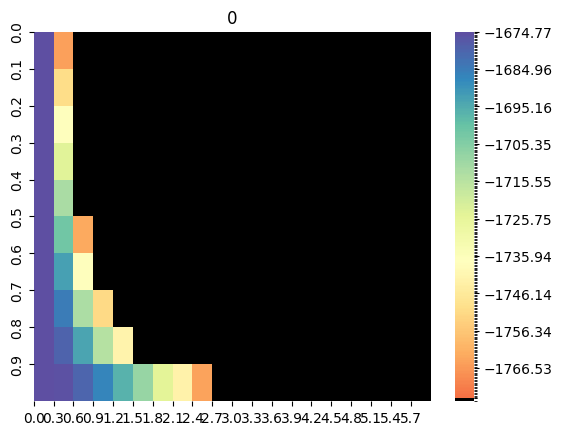

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


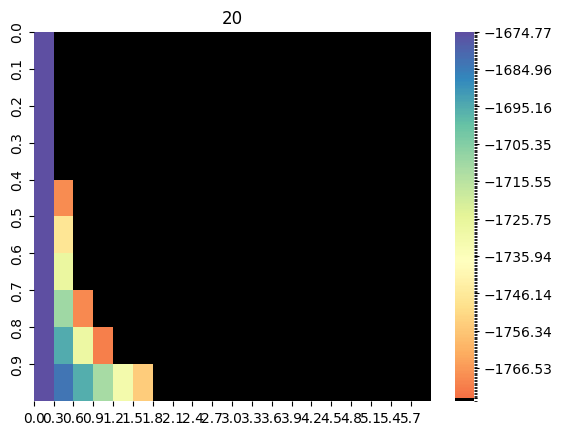

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


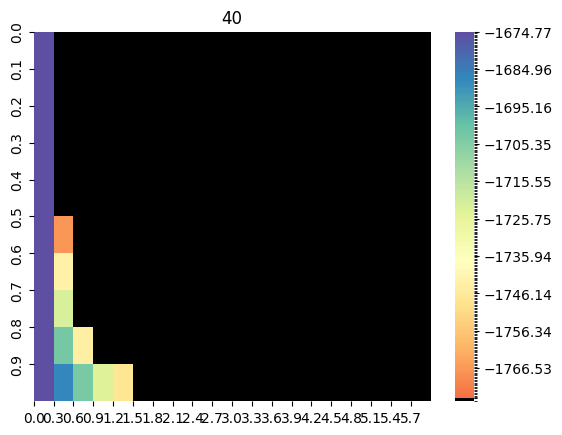

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


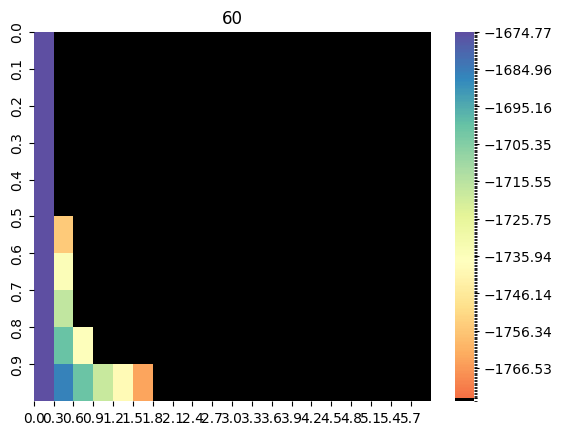

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


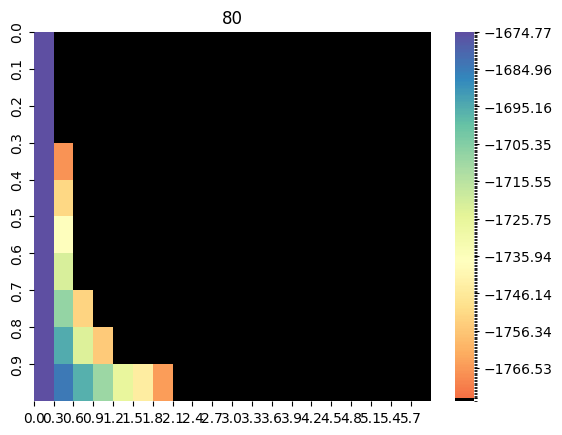

C:\Users\myuhk\AppData\Local\Temp\ipykernel_35632\491669791.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)


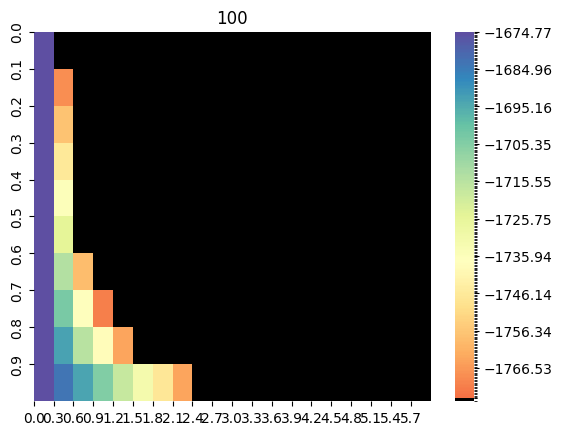

In [ ]:
def new_U_s1(w,s,phi,thresh):
    # corresponds to U_s1(w) in the paper
    return phi*U_soc[w] + (1-phi)*new_U_inf[(w[0],thresh)][s+100]
# s spans from -100 to 100
inten = 'extremely'
for thresh in [-100,-80,-60,-40,-20,0,20,40,60,80,100]:
    new_P_s1 = dict() # corresponds to P_S1(w|s,phi)
    for alpha in possible_alpha:
        for phi in possible_phi:
            for s in states:
                # marginalized over all utterences with same predicate ('slightly' 'kind of' 'quite' 'very' 'extremely')
                for pred in predicates:
                    new_P_s1[(alpha,phi,s,pred)] = softmax([ alpha*new_U_s1((w,pred),s,phi,thresh) if w == inten else alpha*U_s1((w,pred),s,phi)for w in intensifiers])
    # only thing left is computing P_l1
    new_P_l1 = dict()# corresponds to P_L1(s|w,phi)
    for alpha in possible_alpha:
        for phi in possible_phi:
            for pred in predicates:
                i = intensifiers.index(inten)
                w = intensifiers[i]
                P_l1[(alpha,phi,(w,pred))] = [new_P_s1[(alpha,phi,s,pred)][i]*P_state(s) for s in states]
                # normalize so adds up to 1
                P_l1[(alpha,phi,(w,pred))] = P_l1[(alpha,phi,(w,pred))]/np.sum(P_l1[(alpha,phi,(w,pred))])
    fit_judgement=dict()    
    for pred in predicates:
        fit_judgement[pred] = np.zeros((len(possible_phi),len(possible_alpha)))
        measured_values = dialogue[((dialogue['intensifier'] == inten) & (dialogue['predicate'] == pred))]['difference'].values
        for i in range(len(possible_phi)):
            for j in range(len(possible_alpha)):
                fit_judgement[pred][i][j] = np.sum(np.log(P_l1[(possible_alpha[j],possible_phi[i],(inten,pred))][int(s)+100]) for s in measured_values)
    threshold = np.max(np.sum([fit_judgement[pred] for pred in predicates],axis=0))-100
    bounds = [-10000, threshold] + list(np.linspace(threshold, np.max(np.sum([fit_judgement[pred] for pred in predicates],axis=0)), 256))
    norm = BoundaryNorm(bounds, len(bounds) - 1)
    sns.heatmap(np.sum([fit_judgement[pred] for pred in predicates],axis=0), cmap=custom_cmap,norm=norm, cbar=True)
    # label x and y by the possible values
    plt.xticks(range(len(possible_alpha)), [round(x, 2) for x in possible_alpha])
    plt.yticks(range(len(possible_phi)), [round(x, 2) for x in possible_phi])
    # label colors in heatmap
    plt.title(f'{thresh}')
    plt.show()
    
                
